In [1]:
from Scripts.ProcessingEmbeddings import *
from Scripts.HardDebias import *
from Scripts.utils import *

In [2]:
import codecs
import json
import numpy as np
import sklearn

In [3]:
glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)

Loading Data/glove-wiki-gigaword-300.txt embeddings
vectors shape: (400000, 300), word2idx length: 400000, vocab length: 400000


In [4]:
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()


In [5]:
np.isnan(vectors).any()

False

In [6]:
# Getting a limited vocabulary to debias the embeddings.
vocab_nopunct, vectors_nopunct, word2idx_nopunct, dict_vec_nopunct = glove.limit_vocab(vectors, word2idx, vocab)

100%|██████████| 400000/400000 [00:00<00:00, 609482.18it/s]


Size of limited vocabulary: 327185


## Hard-Debias Algorithm

#### Preliminaries

In [9]:
#Gender specific vocabulary:
gender_specific=[]
female_vocab=[]
male_vocab=[]
with open('./Data/male_word_file.txt') as f:
    male_vocab = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        female_vocab.append(l.strip())

gender_specific=female_vocab+female_vocab

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

In [10]:
# Getting a limited vocabulary to debias the embeddings.
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(
    vectors, word2idx, vocab)


100%|██████████| 400000/400000 [00:00<00:00, 610525.71it/s]


Size of limited vocabulary: 327185


In [11]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets = {
    "gender": [
        ['she', 'he'], ['herself', 'himself'], [
            'her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
        ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'], ['aunt', 'uncle']],

    "race": [
        ["black", "caucasian", "asian", "hispanic"],
      		["african", "caucasian", "asian", "hispanic"],
      		["black", "white", "asian", "latino"],
      		["africa", "europe", "asia", "mexico"],
      		["africa", "america", "china", "latin-america"],
    ]
}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], [
            "Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], [
            "grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], [
            "wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], [
            "brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman",
                                                        "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], [
            "fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], [
            "gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], [
            "his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], [
            "men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]]}

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


In [12]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],


}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]


In [13]:
euroam_names = ["Adam", "Alan", "Allison", "Amanda", "Amber", "Andrew", "Anne", "Betsy", "Bobbie-Sue", "Brad", "Brandon", "Brendan", "Brett", "Carrie", "Chip", "Colleen", "Courtney", "Crystal", "Donna", "Ellen", "Emily", "Frank", "Fred", "Geoffrey", "Greg", "Hank", "Harry", "Heather", "Ian", "Jack", "Jay",
                "Jed", "Jill", "Jonathan", "Josh", "Justin", "Katie", "Kristen", "Kristin", "Lauren", "Laurie", "Matthew", "Megan", "Melanie", "Meredith", "Nancy", "Neil", "Neil", "Paul", "Peggy", "Peter", "Rachel", "Roger", "Ryan", "Sara", "Sarah", "Shannon", "Stephanie", "Stephen", "Sue-Ellen", "Todd", "Wendy", "Wilbur"]

africanam_names = ["Aiesha", "Aisha", "Alonzo", "Alphonse", "Darnell", "Deion", "Ebony", "Everol", "Hakim", "Jamal", "Jamel", "Jasmine", "Jermaine", "Jerome", "Kareem", "Keisha", "Kenya", "Lakisha", "Lamar", "Lamont", "Lashandra", "Lashelle", "Latisha", "Latonya", "Latoya", "Lavon", "Lerone", "Leroy", "Lionel", "Malik", "Malika", "Marcellus", "Nichelle", "Percell", "Rasaan", "Rashaun", "Rasheed", "Shaniqua", "Shanise", "Sharise", "Shavonn", "Shereen", "Tameisha", "Tamika", "Tanisha",
                   "Tashika", "Tawanda", "Temeka", "Teretha", "Terrence", "Terryl", "Theo", "Tia", "Torrance", "Tremayne", "Tyree", "Tyrone", "Wardell", "Yolanda", "Yvette"]


In [14]:
#Function to prepare the def_set_lists for the debiasing
def prepare_def_sets_subspace(list_def_sets):
  def_sets={i: v for i, v in enumerate(list_def_sets)}
  return def_sets

def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])
def_set_joined=utils.prepare_def_sets_subspace(def_sets["gender"]+ def_sets["race"])

In [15]:
equalizing_lists['race']=get_pairs_from_equalizing_sets(def_sets['race'])


In [16]:
equalizing_lists['intersection']=get_pairs(def_sets['gender'], def_sets['race'])


#### Gender

In [17]:
deb_vect_gender, deb_vocab_gender, deb_word2idx_gender,deb_dict_gender = hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists['gender'], 
                             def_set_gender,
                             1,
                             normalize_dir=False,
                             normalize=None,
                             centralizing=True)

Length of vectors set: 22
Running PCA with 1 components


#### Joint

In [ ]:
deb_vect_joined, deb_vocab_joined, deb_word2idx_joined, deb_dict_joined = hard_debias(vectors,
                                                                            dict_vectors,
                                                                              word2idx_cleaned,
                                                                              vocab_cleaned,
                                                                              equalizing_lists['intersection'],
                                                                              def_set_joined,
                                                                              1,
                                                                              normalize_dir=False,
                                                                              normalize=None,
                                                                              centralizing=True)


## Evaluation

In [18]:
from Scripts.Visualization import *
from Scripts.Evaluation import *
import pandas as pd

### Analogies

In [17]:
get_term_analogies(dict_vectors, 'man', 'programmer', 'woman', include_triplet=True)

('programmer', 0.8261464)

In [18]:
get_term_analogies(dict_vec_cleaned, 'cloud',
                   'clouds', 'drink', include_triplet=False)


('appalachians', 0.33512446749961766)

In [19]:
glove.model.most_similar(
    positive=['man', 'programmer'], negative=["woman"])


[('programmers', 0.5212790966033936),
 ('computer', 0.44369009137153625),
 ('software', 0.44298413395881653),
 ('engineer', 0.413945734500885),
 ('developer', 0.39335253834724426),
 ('animator', 0.38950908184051514),
 ('creator', 0.3716830611228943),
 ('hacker', 0.36401066184043884),
 ('user', 0.35467666387557983),
 ('programming', 0.3529259264469147)]

In [20]:
get_term_analogies(dict_vec_cleaned, 'France', 'Paris', 'Japan')

('tokyo', 0.668361123303409)

### Gender Bias Pre-Post

In [56]:
# To compute the gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']

# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
gender_bias_original = compute_gender_simple_bias(dict_vec_cleaned, he_embed, she_embed)

In [57]:
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)


Length of vectors set: 22
Running PCA with 1 components


In [58]:
gender_bias_original2 = compute_direct_bias(
    dict_vectors, vocab_cleaned, gender_direction)


In [59]:
compute_average_bias(deb_dict_gender, neutral_words, gender_direction)


3.755074655801935e-09

In [60]:
gender_bias_original2 = compute_direct_bias(
    deb_dict_gender, neutral_words, gender_direction)


In [61]:
gender_bias_after_debiasing=compute_gender_simple_bias(deb_dict_gender, he_embed, she_embed)

In [62]:
occupations = ['assistant','secretary','data scientist', 'scientist', 'politician','janitor', 'hairdresser','teacher', 'bartender','midwife','doctor','ballerina','dancer','pediatrician','surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists','carpenter','clerk','manager','supervisor','driver','software developer','lawyer','pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro','lecturer','salesperson','homemaker', 'receptionist','librarian', 'nanny', 'bookkeeper', 'stylist','housekeeper','guidance counselor','skipper', 'protege','philosopher','captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher','pilot', 'boss']


In [63]:
bias_df=get_bias_score_df_from_list(gender_bias_original,gender_bias_after_debiasing, occupations,vocab_cleaned,deb_vocab_gender)
plot_bias_bar(bias_df, "Gender bias on occupations (original vs debiased)", "Occupations")

In [64]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(gender_bias_original, def_sets['gender'], 1000, word2idx)


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



precision 0.0


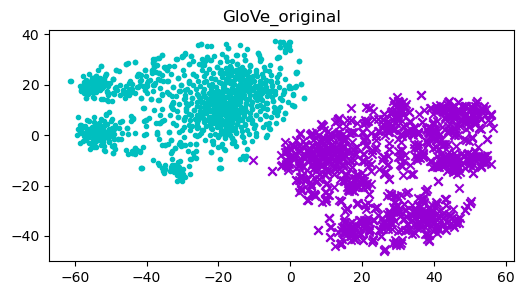

In [30]:
gendered_vectors=utils.extract_vectors(male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      gendered_vectors, 'GloVe_original', y_true)


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



precision 0.4895


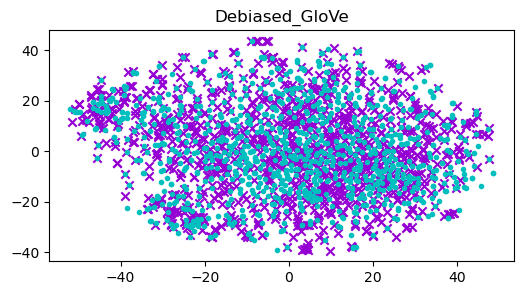

In [31]:
gendered_debiased_vectors = utils.extract_vectors(
    male_words + female_words, deb_vect_gender, deb_word2idx_gender)

cluster_and_visualize(male_words + female_words, gendered_debiased_vectors,
                      'Debiased_GloVe', y_true)


###  Random Words: bias scores and neighbors

In [55]:
from collections import defaultdict
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=20)

#setting parameters for the gensim method "most_similar"
topn = 3


In [56]:
random_words

array(['kuong', 'monagas', 'prah', 'bitel', 'haemostasis', 'latham',
       'ukulele', 'chawton', 'bachner', 'geres', 'lohn', 'statutorily',
       'kallmann', 'nazzaro', 'pocar', 'solel', 'śakti', 'agnete', 'vgn',
       'americain'], dtype='<U19')

In [57]:
#Getting the gender bias score for the random words list
bias_df = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, random_words, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df, "Gender bias on random_words (original vs debiased)", "Random_words")


In [58]:
#Sanity checks
#Gensim's .most_similar() method finds the top-N most similar words to a given word.
#See documentation: https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
glove.model.most_similar(random_words[0], topn=10)
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)
model_original.most_similar(random_words[0], topn=3)


[('desra', 0.5968402624130249),
 ('vlaikov', 0.569767951965332),
 ('tsanchev', 0.5665053725242615)]

In [59]:
get_topK_neighbors(random_words[0], dict_vec_cleaned,
                   vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=10)


({'kuong': [('desra', 0.5968402350200581),
   ('vlaikov', 0.569767998962087),
   ('tsanchev', 0.5665053135193753),
   ('faizasyah', 0.5613936916080458),
   ('chanthalangsy', 0.5611222947658795),
   ('charungvat', 0.5603197155969383),
   ('wahide', 0.5501852139271813),
   ('nezir', 0.549970310431392),
   ('delavekouras', 0.5484409613022618),
   ('ygal', 0.5459976262335)]},
 ['desra',
  'vlaikov',
  'tsanchev',
  'faizasyah',
  'chanthalangsy',
  'charungvat',
  'wahide',
  'nezir',
  'delavekouras',
  'ygal'])

In [60]:
def get_topK_neighbors_optimized(word, dict_vect, vocab, vectors, w2i, k=10):
    """
    Function to find the top-k most similar words to a given word using the cosine similarity
    :param word: word to compute the bias for
    :param dict_vect: dictionary of words and their embeddings
    :param vocab: list of words in the vocabulary
    :param vectors: list of embeddings
    :param w2i: dictionary of words and their indices
    :param k: number of neighbors to find
    :return: list of the top-k most similar words to the given word
    """
    idx = w2i[word]
    chosen_vec = dict_vect[word]

    # compute cosine similarity between chosen_vec and all other words. Store in similarities list
    similarities = np.dot(vectors, chosen_vec)

    # sort similarities by descending order
    sorted_similarities = np.argsort(similarities)[::-1]

    # choose topK
    best = sorted_similarities[:k]

    # create a list with the word for each of the topK words
    list_neigh = [vocab[i] for i in best if i != idx]
    return list_neigh


In [61]:
k_neigh= get_k_nearest_neighbors(random_words, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)

100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


In [62]:
list_neigh = get_list_neighbors(k_neigh)

In [63]:
neig_freq2=get_frequency_original_neighbors(
    random_words, list_neigh, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)


20it [00:31,  1.58s/it]


In [64]:
df = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])


In [65]:
import plotly_express as px
#plot the frequency of the original neighbours in the debiased network in a horizontal bar chart

fig = px.bar(df, x='word', y='freq', title='Proportion of original 50 neighbours in the debiased k-vicinity of each word',
             labels={'freq':'Proportion', 'word':'Word'},
             height=500, width=1000)
#update the layout of the plot: update the y axis to be between 0 and 0.5 and the x axis to include all ticks
fig.update_layout(yaxis=dict(range=[0, 0.5]))

fig.show()

In [66]:
#Getting the neighbors of debiased vectors the Gensim way
gender_debiased = create_KeyedVectors(deb_vect_gender, deb_vocab_gender, 300)
finding_neighbors_before_after(random_words, model_original, gender_debiased, topn=50)

----------------------------------
word: kuong
 most-similar-before: ('desra', 'vlaikov', 'tsanchev', 'faizasyah', 'chanthalangsy', 'charungvat', 'wahide', 'nezir', 'delavekouras', 'ygal', 'kristiarto', 'ozugergin', 'percaya', 'utkan', 'ingvard', 'elkhan', 'hatsuhisa', 'lyakin', 'jayanama', 'bilman', 'palmor', 'phuangketkeow', 'ladsous', 'gomelauri', 'supriyadi', 'klepsvik', 'szentivanyi', 'koy', 'zanolari', 'launsky', 'panchenkov', 'mugume', 'therence', 'buluc', 'zakirov', 'opletalova', 'imerslund', 'ternert', 'baheen', 'khenthong', 'donadze', 'goranov', 'spalinski', 'nurkan', 'paszkowski', 'markian', 'sihasak', 'shimanouchi', 'karassin', 'sinunguruza')
 most-similar-after: ('blanchfield', 'cybersquatting', 'ainun', 'barki', 'skeppsbron', 'diamper', 'needier', 'unicaja', 'jacki', 'intrahepatic', 'etō', 'angulatus', 'momence', 'frederiksen', 'bullecourt', 'rafel', 'gottfried', 'bootle', 'benzes', 'uppish', 'realities', 'reconfigures', 'canker', 'ride', 'brunson', 'lissek', 'yevoli', 'l

defaultdict(dict,
            {'kuong': {'before': ('desra',
               'vlaikov',
               'tsanchev',
               'faizasyah',
               'chanthalangsy',
               'charungvat',
               'wahide',
               'nezir',
               'delavekouras',
               'ygal',
               'kristiarto',
               'ozugergin',
               'percaya',
               'utkan',
               'ingvard',
               'elkhan',
               'hatsuhisa',
               'lyakin',
               'jayanama',
               'bilman',
               'palmor',
               'phuangketkeow',
               'ladsous',
               'gomelauri',
               'supriyadi',
               'klepsvik',
               'szentivanyi',
               'koy',
               'zanolari',
               'launsky',
               'panchenkov',
               'mugume',
               'therence',
               'buluc',
               'zakirov',
               'opletalova',


In [67]:
k_neigh= get_k_nearest_neighbors(random_words, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=50)

100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


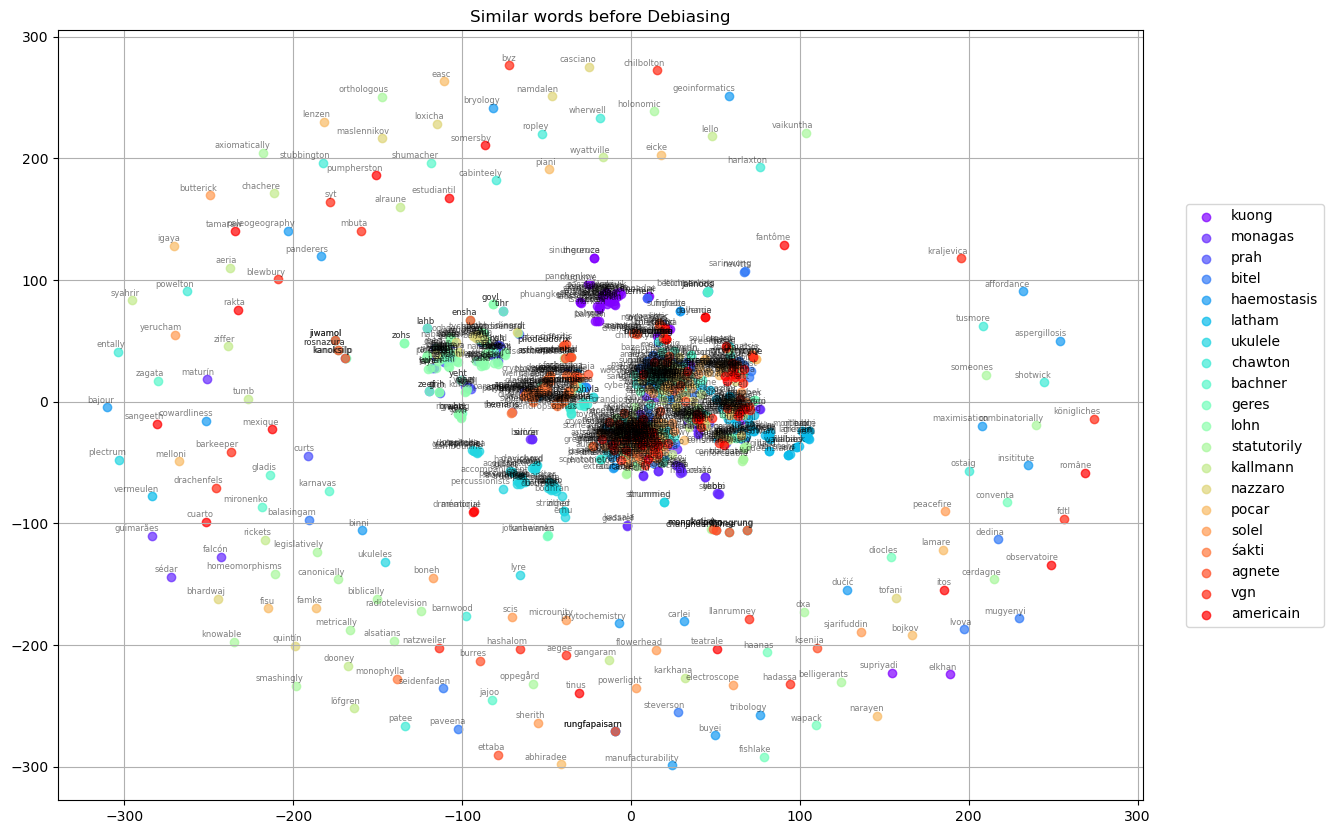

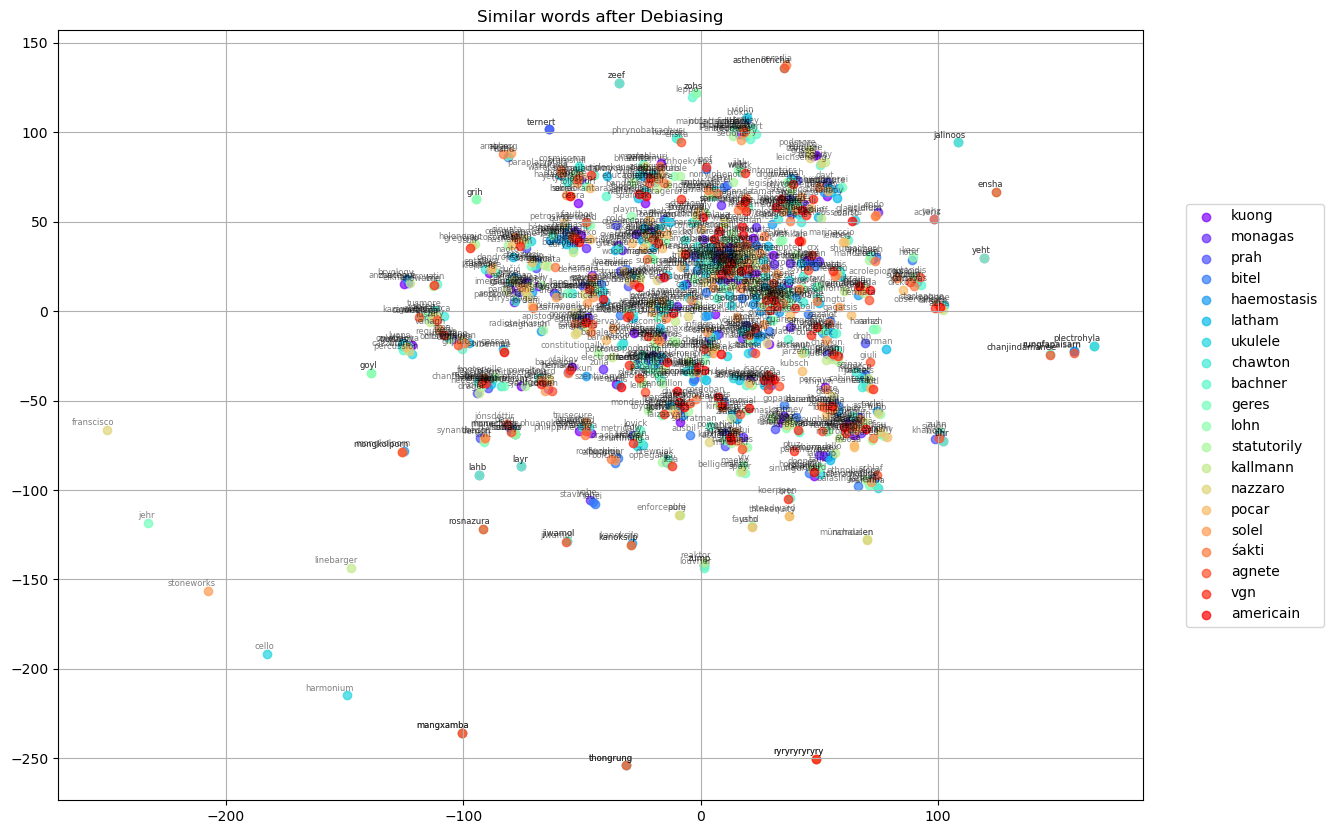

In [68]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, gender_debiased, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


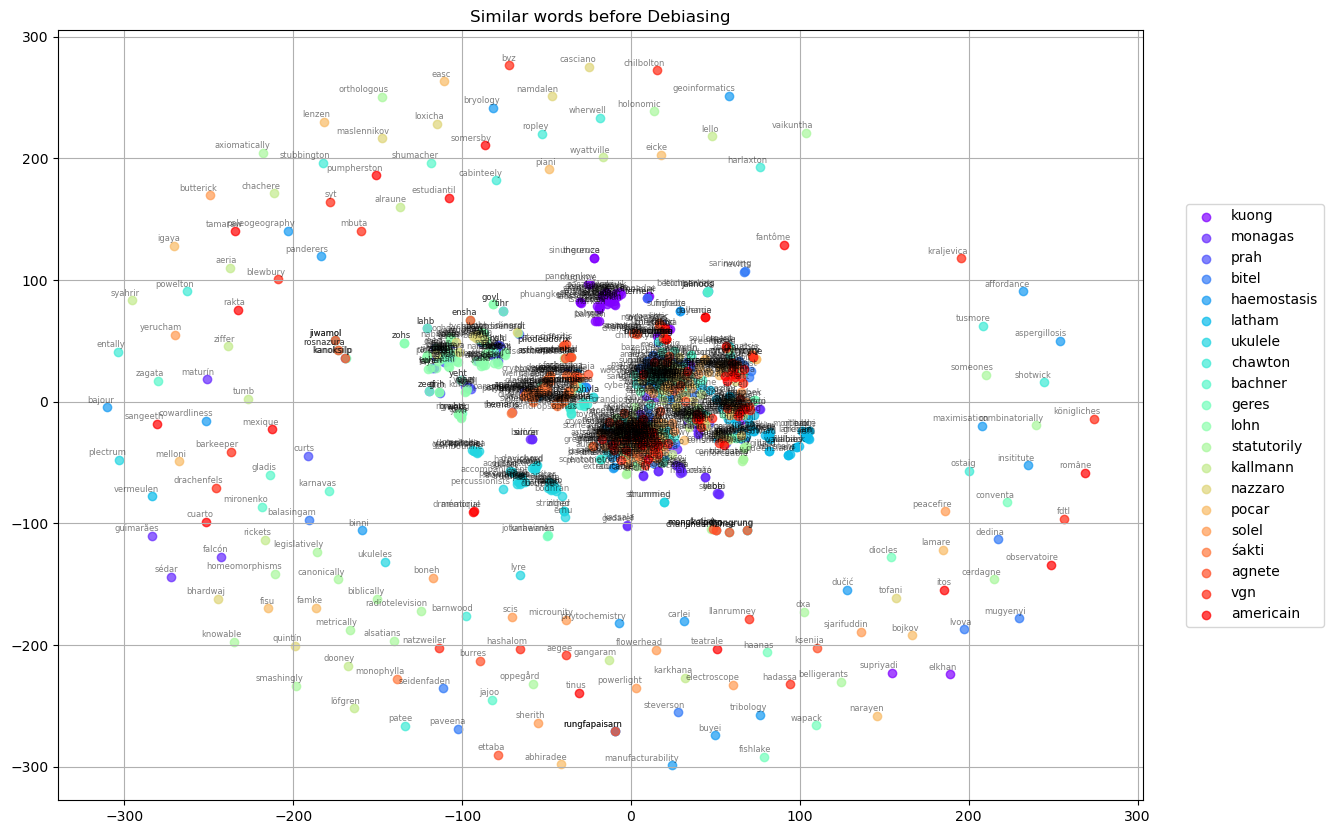

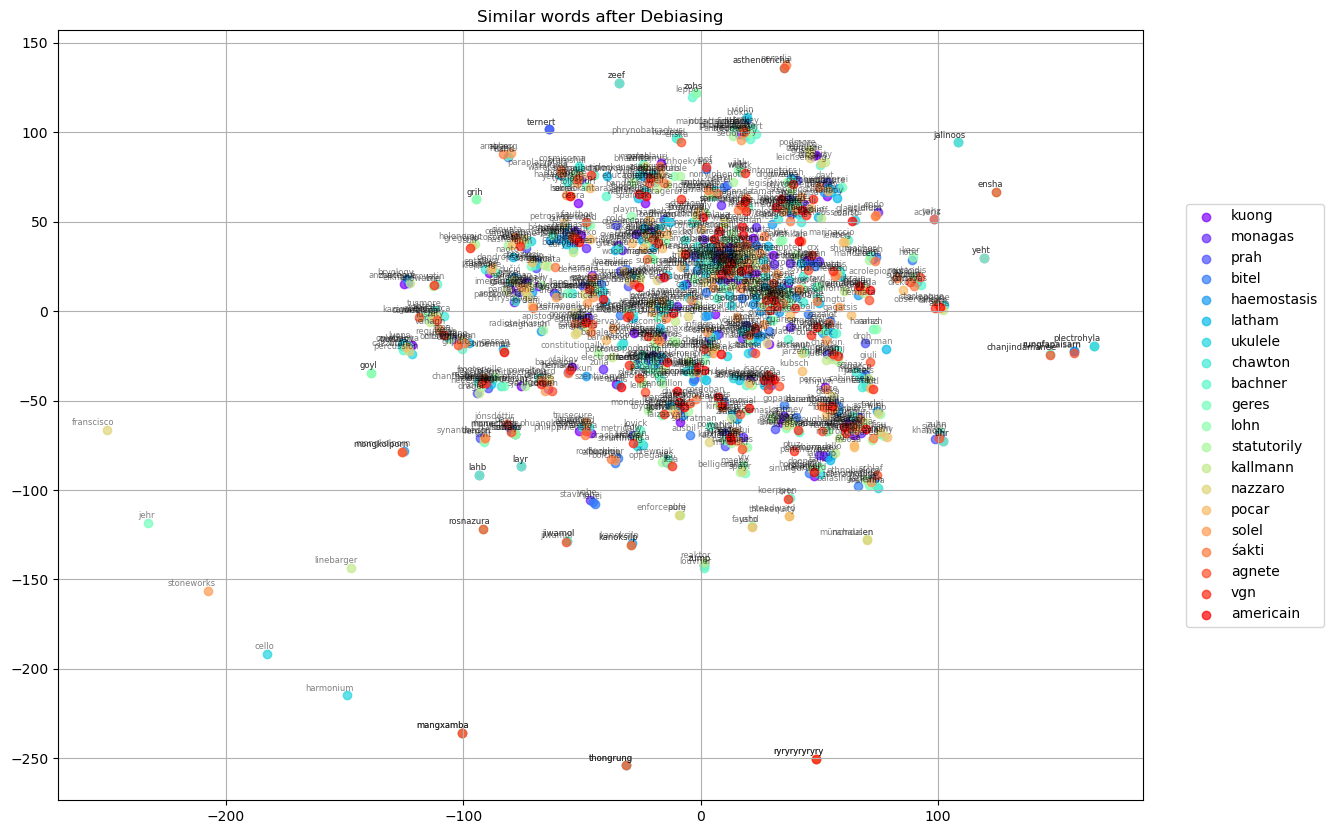

In [69]:
tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


In [70]:
distances_original,distances_debiased=get_distance_to_neighbors(random_words, list_neigh,
                          dict_vec_cleaned, deb_dict_gender)


In [19]:
#get dataframe of distances from distances_original and distances_debiased
def get_df_distances(distances_original,distances_debiased):
    df=pd.DataFrame()
    for word in distances_original.keys():
        for i in range(len(distances_original[word])):
            #df=df.append({'word':word, 'neighbor':distances_original[word][i][0], 'distance_original':distances_original[word][i][1], 'distance_debiased':distances_debiased[word][i][1]}, ignore_index=True)
            df=pd.concat([df, pd.DataFrame.from_records([{'word':word, 'neighbor':distances_original[word][i][0], 'distance_original':distances_original[word][i][1], 'distance_debiased':distances_debiased[word][i][1]}])], ignore_index=True)
            
    return df

In [72]:
df_neigh_distances=get_df_distances(distances_original,distances_debiased)

#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#now add a column of the difference between the two mean distances
df_average['difference']=abs(df_average['distance_original']-df_average['distance_debiased'])

df_average=df_average.sort_values(by='difference', ascending=True)
df_average=df_average.rename(columns={'distance_original':'average distance to neighbors (original embeddings)', 'distance_debiased':'average distance to neighbors (debiased embeddings)'})

In [73]:
df_average


average distance to neighbors (original embeddings)  \
word                                                               
latham                                                0.648433     
pocar                                                 0.635407     
kallmann                                              0.629730     
americain                                             0.635428     
vgn                                                   0.624645     
monagas                                               0.635808     
solel                                                 0.590789     
nazzaro                                               0.619361     
statutorily                                           0.646444     
haemostasis                                           0.560639     
bachner                                               0.557806     
chawton                                               0.566171     
geres                                                 0.548564     
bitel                                                 0.554770     
prah                                                  0.541000     
kuong                                                 0.483883     
agnete                                                0.511993     
lohn                                                  0.517429     
śakti                                                 0.448899     
ukulele                                               0.530026     

             average distance to neighbors (debiased embeddings)  difference  
word                                                                          
latham                                                1.020139      0.371706  
pocar                                                 1.053084      0.417677  
kallmann                                              1.057955      0.428225  
americain                                             1.077955      0.442527  
vgn                                                   1.079489      0.454844  
monagas                                               1.090878      0.455070  
solel                                                 1.049800      0.459011  
nazzaro                                               1.081212      0.461851  
statutorily                                           1.116082      0.469638  
haemostasis                                           1.042201      0.481561  
bachner                                               1.044780      0.486974  
chawton                                               1.064967      0.498796  
geres                                                 1.053455      0.504892  
bitel                                                 1.063697      0.508926  
prah                                                  1.051564      0.510564  
kuong                                                 1.038657      0.554773  
agnete                                                1.081356      0.569362  
lohn                                                  1.087844      0.570415  
śakti                                                 1.054536      0.605637  
ukulele                                               1.144606      0.614579

In [74]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_average.index, y=df_average['average distance to neighbors (original embeddings)'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_average.index, y=df_average['average distance to neighbors (debiased embeddings)'], name='Debiased Embeddings'))
#add title
fig.update_layout(title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()

In [75]:
#merge df and df average on word
df_merged=df.merge(df_average, on='word')
df_merged


word  previous_neighbours  freq  \
0         kuong                    0   0.0   
1       monagas                    0   0.0   
2          prah                    0   0.0   
3         bitel                    0   0.0   
4   haemostasis                    0   0.0   
5        latham                    0   0.0   
6       ukulele                    0   0.0   
7       chawton                    0   0.0   
8       bachner                    0   0.0   
9         geres                    0   0.0   
10         lohn                    0   0.0   
11  statutorily                    0   0.0   
12     kallmann                    0   0.0   
13      nazzaro                    0   0.0   
14        pocar                    0   0.0   
15        solel                    0   0.0   
16        śakti                    0   0.0   
17       agnete                    0   0.0   
18          vgn                    0   0.0   
19    americain                    0   0.0   

    average distance to neighbors (original embeddings)  \
0                                            0.483883     
1                                            0.635808     
2                                            0.541000     
3                                            0.554770     
4                                            0.560639     
5                                            0.648433     
6                                            0.530026     
7                                            0.566171     
8                                            0.557806     
9                                            0.548564     
10                                           0.517429     
11                                           0.646444     
12                                           0.629730     
13                                           0.619361     
14                                           0.635407     
15                                           0.590789     
16                                           0.448899     
17                                           0.511993     
18                                           0.624645     
19                                           0.635428     

    average distance to neighbors (debiased embeddings)  difference  
0                                            1.038657      0.554773  
1                                            1.090878      0.455070  
2                                            1.051564      0.510564  
3                                            1.063697      0.508926  
4                                            1.042201      0.481561  
5                                            1.020139      0.371706  
6                                            1.144606      0.614579  
7                                            1.064967      0.498796  
8                                            1.044780      0.486974  
9                                            1.053455      0.504892  
10                                           1.087844      0.570415  
11                                           1.116082      0.469638  
12                                           1.057955      0.428225  
13                                           1.081212      0.461851  
14                                           1.053084      0.417677  
15                                           1.049800      0.459011  
16                                           1.054536      0.605637  
17                                           1.081356      0.569362  
18                                           1.079489      0.454844  
19                                           1.077955      0.442527

In [76]:
df_merged


word  previous_neighbours  freq  \
0         kuong                    0   0.0   
1       monagas                    0   0.0   
2          prah                    0   0.0   
3         bitel                    0   0.0   
4   haemostasis                    0   0.0   
5        latham                    0   0.0   
6       ukulele                    0   0.0   
7       chawton                    0   0.0   
8       bachner                    0   0.0   
9         geres                    0   0.0   
10         lohn                    0   0.0   
11  statutorily                    0   0.0   
12     kallmann                    0   0.0   
13      nazzaro                    0   0.0   
14        pocar                    0   0.0   
15        solel                    0   0.0   
16        śakti                    0   0.0   
17       agnete                    0   0.0   
18          vgn                    0   0.0   
19    americain                    0   0.0   

    average distance to neighbors (original embeddings)  \
0                                            0.483883     
1                                            0.635808     
2                                            0.541000     
3                                            0.554770     
4                                            0.560639     
5                                            0.648433     
6                                            0.530026     
7                                            0.566171     
8                                            0.557806     
9                                            0.548564     
10                                           0.517429     
11                                           0.646444     
12                                           0.629730     
13                                           0.619361     
14                                           0.635407     
15                                           0.590789     
16                                           0.448899     
17                                           0.511993     
18                                           0.624645     
19                                           0.635428     

    average distance to neighbors (debiased embeddings)  difference  
0                                            1.038657      0.554773  
1                                            1.090878      0.455070  
2                                            1.051564      0.510564  
3                                            1.063697      0.508926  
4                                            1.042201      0.481561  
5                                            1.020139      0.371706  
6                                            1.144606      0.614579  
7                                            1.064967      0.498796  
8                                            1.044780      0.486974  
9                                            1.053455      0.504892  
10                                           1.087844      0.570415  
11                                           1.116082      0.469638  
12                                           1.057955      0.428225  
13                                           1.081212      0.461851  
14                                           1.053084      0.417677  
15                                           1.049800      0.459011  
16                                           1.054536      0.605637  
17                                           1.081356      0.569362  
18                                           1.079489      0.454844  
19                                           1.077955      0.442527

In [49]:
#create a function to run the whole process of getting the neighbors of the original vectors and the debiased vectors and then getting the average distance to neighbors before and after debiasing for random words 1000 times
# return a dataframe with the average distance to neighbors before and after debiasing for each iteration
def get_df_random_words_neighbor_analysis(dict_vects, deb_dict, deb_vocab, deb_vect, deb_word2idx, k=2, size_random_set=2):
    df=pd.DataFrame()
    
   
    random_words = np.random.choice(vocab_cleaned[:10000], size=size_random_set)
    #get the neighbors of the original vectors
    k_neigh_original= get_k_nearest_neighbors(random_words, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=k)

    #create gender word list for word in both k_neigh_debiased.keys() and k_neigh_original_g.keys()
    
    list_neigh_original=get_list_neighbors(k_neigh_original)

    rand_words = [word for word in random_words if word in 
        k_neigh_original.keys()]
    #get the neighbors of the debiased vectors
    #k_neigh_debiased= get_k_nearest_neighbors(random_words, deb_dict, deb_vocab, deb_vect, deb_word2idx, k=k)
    #get the distances to neighbors before and after debiasing
    distances_original, distances_debiased = get_distance_to_neighbors(rand_words, list_neigh_original,
                          dict_vects, deb_dict)
    #get dataframe of distances from distances_original and distances_debiased
    df_neigh_distances=get_df_distances(distances_original,distances_debiased)
    #use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
    df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()
        
    #frequencies of neighbors
    neig_freq2 = get_frequency_original_neighbors(
        rand_words, list_neigh_original, deb_dict, deb_vocab, deb_vect, deb_word2idx, neighbours_num=k)
    df2 = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])
    #merge the two dataframes on the word column
    #merge df and df average on word
    df_merged=df2.merge(df_average, on='word')
    #df=pd.concat([df,df_merged], axis=1, keys='words')
        
    return df_merged


In [50]:
#get function to get the values of the average distance to neighbors before and after debiasing for each iteration
def get_df_random_words_neighbor_analysis_values(dict_vects, deb_dict, deb_vocab, deb_vect, deb_word2idx, k=2, num_iterations=1000, size_random_set=2):
    grand_df=pd.DataFrame()
    for i in range(num_iterations):
        df1=get_df_random_words_neighbor_analysis(dict_vects, deb_dict, deb_vocab,
                         deb_vect, deb_word2idx, k=k, size_random_set=size_random_set)
        df1['iteration']=i
        grand_df=pd.concat([grand_df, df1])
    return grand_df

In [51]:
df_merged=get_df_random_words_neighbor_analysis_values(
    dict_vec_cleaned, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=50, num_iterations=50, size_random_set=20)


100%|██████████| 20/20 [00:33<00:00,  1.66s/it]
3it [00:05,  1.70s/it]

involving


7it [00:11,  1.67s/it]

really


9it [00:15,  1.66s/it]

could


10it [00:16,  1.66s/it]

contracts


16it [00:26,  1.66s/it]

customer


17it [00:28,  1.66s/it]

refugees


20it [00:33,  1.66s/it]
100%|██████████| 20/20 [00:32<00:00,  1.64s/it]
1it [00:01,  1.65s/it]

political


2it [00:03,  1.66s/it]

mother
brothers
boy
niece
sons
grandson
dad
son
aunt
grandmother


4it [00:06,  1.65s/it]

niece
king
man
grandson
grandmother
sons
sister
boy
brothers


6it [00:09,  1.65s/it]

votes


10it [00:16,  1.65s/it]

ecclesiastical


11it [00:18,  1.65s/it]

offers


13it [00:21,  1.66s/it]

parties


20it [00:33,  1.65s/it]


out


100%|██████████| 20/20 [00:32<00:00,  1.64s/it]
7it [00:11,  1.65s/it]

flight


9it [00:14,  1.65s/it]

back
after
goal


16it [00:26,  1.65s/it]

indoor


17it [00:28,  1.65s/it]

comp


20it [00:32,  1.65s/it]
100%|██████████| 20/20 [00:32<00:00,  1.65s/it]
7it [00:11,  1.65s/it]

need


16it [00:26,  1.64s/it]

sony
fundamental


20it [00:32,  1.65s/it]
100%|██████████| 20/20 [00:32<00:00,  1.64s/it]
1it [00:01,  1.65s/it]

gains


2it [00:03,  1.65s/it]

company
industry


5it [00:08,  1.65s/it]

everything


12it [00:19,  1.65s/it]

once
before


13it [00:21,  1.65s/it]

taliban


16it [00:26,  1.66s/it]

all
sunday
they
tuesday


17it [00:28,  1.66s/it]

voter


20it [00:33,  1.65s/it]
100%|██████████| 20/20 [00:32<00:00,  1.65s/it]
4it [00:06,  1.66s/it]

so
some
to
out
find


8it [00:13,  1.66s/it]

lawmakers


14it [00:23,  1.66s/it]

just
to
after
back
of


17it [00:28,  1.67s/it]

annual


20it [00:33,  1.66s/it]
100%|██████████| 20/20 [00:33<00:00,  1.66s/it]
7it [00:11,  1.70s/it]

influential


9it [00:15,  1.70s/it]

later
its


11it [00:18,  1.69s/it]

monkey


20it [00:33,  1.69s/it]
100%|██████████| 20/20 [00:33<00:00,  1.67s/it]
2it [00:03,  1.68s/it]

gains


3it [00:05,  1.67s/it]

x


4it [00:06,  1.73s/it]

involving


6it [00:10,  1.71s/it]

know


13it [00:21,  1.66s/it]

income


14it [00:23,  1.66s/it]

strategy


16it [00:26,  1.67s/it]

or
being
other
some
rather


20it [00:33,  1.68s/it]
100%|██████████| 20/20 [00:33<00:00,  1.67s/it]
6it [00:09,  1.66s/it]

will


15it [00:24,  1.66s/it]

alleging


16it [00:26,  1.66s/it]

doctors
experiments
authors


20it [00:33,  1.66s/it]
100%|██████████| 20/20 [00:32<00:00,  1.65s/it]
19it [00:31,  1.64s/it]

alleging


20it [00:32,  1.65s/it]


did
will
them
so


100%|██████████| 20/20 [00:33<00:00,  1.66s/it]
1it [00:01,  1.65s/it]

likelihood


2it [00:03,  1.65s/it]

none


3it [00:04,  1.65s/it]

resolve


9it [00:14,  1.63s/it]

only
since
night
earlier
three


13it [00:21,  1.64s/it]

until


15it [00:24,  1.64s/it]

girl
daughter
lady
granddaughter
prince
daughters


18it [00:29,  1.64s/it]

minorities


19it [00:31,  1.64s/it]

meetings


20it [00:32,  1.64s/it]


parties


100%|██████████| 20/20 [00:32<00:00,  1.65s/it]
4it [00:06,  1.65s/it]

expectations
same
could
possible


6it [00:09,  1.65s/it]

electrical


9it [00:14,  1.65s/it]

making
began
did


12it [00:19,  1.65s/it]

given


20it [00:32,  1.65s/it]
100%|██████████| 20/20 [00:33<00:00,  1.66s/it]
1it [00:01,  1.63s/it]

mph


9it [00:14,  1.63s/it]

longest


10it [00:16,  1.64s/it]

example


17it [00:27,  1.64s/it]

investor


19it [00:31,  1.64s/it]

classical


20it [00:32,  1.64s/it]
100%|██████████| 20/20 [00:33<00:00,  1.65s/it]
8it [00:13,  1.64s/it]

roof


10it [00:16,  1.65s/it]

any


16it [00:26,  1.64s/it]

which
second
if
just
time


20it [00:32,  1.65s/it]
100%|██████████| 20/20 [00:33<00:00,  1.66s/it]
2it [00:03,  1.65s/it]

ireland


4it [00:06,  1.65s/it]

company


5it [00:08,  1.65s/it]

could


6it [00:09,  1.65s/it]

did
believe


9it [00:14,  1.65s/it]

following
war
after
later


13it [00:21,  1.65s/it]

organization


16it [00:26,  1.64s/it]

ever


19it [00:31,  1.65s/it]

deployed


20it [00:32,  1.65s/it]
100%|██████████| 20/20 [00:33<00:00,  1.65s/it]
4it [00:06,  1.65s/it]

horse


5it [00:08,  1.64s/it]

immigrant


8it [00:13,  1.65s/it]

girl
females
men
male
woman


20it [00:32,  1.64s/it]
100%|██████████| 20/20 [00:32<00:00,  1.65s/it]
1it [00:01,  1.63s/it]

shortly


3it [00:04,  1.62s/it]

after
so
will


5it [00:08,  1.63s/it]

appeal


7it [00:11,  1.62s/it]

sound


8it [00:12,  1.62s/it]

later
after
last
year


11it [00:17,  1.62s/it]

conflicts


13it [00:21,  1.62s/it]

salzburg


15it [00:24,  1.62s/it]

decided
after
could


19it [00:30,  1.62s/it]

time
much
like
country


20it [00:32,  1.63s/it]
100%|██████████| 20/20 [00:32<00:00,  1.64s/it]
14it [00:23,  1.66s/it]

time
only
although
never


17it [00:28,  1.65s/it]

delighted


20it [00:33,  1.65s/it]
100%|██████████| 20/20 [00:33<00:00,  1.65s/it]
8it [00:13,  1.66s/it]

study


13it [00:21,  1.64s/it]

amendment


20it [00:33,  1.65s/it]
100%|██████████| 20/20 [00:32<00:00,  1.65s/it]
10it [00:16,  1.62s/it]

parliamentary


18it [00:29,  1.62s/it]

across


20it [00:32,  1.62s/it]
100%|██████████| 20/20 [00:32<00:00,  1.62s/it]
1it [00:01,  1.62s/it]

or
so
no
did


17it [00:27,  1.62s/it]

which
leading
where
other
also


20it [00:32,  1.62s/it]


police
reporters


100%|██████████| 20/20 [00:32<00:00,  1.64s/it]
1it [00:01,  1.64s/it]

you


8it [00:13,  1.65s/it]

make


9it [00:14,  1.65s/it]

seen
making


11it [00:18,  1.65s/it]

reason


13it [00:21,  1.65s/it]

wednesday
week


16it [00:26,  1.65s/it]

given


20it [00:32,  1.65s/it]
100%|██████████| 20/20 [00:32<00:00,  1.64s/it]
2it [00:03,  1.63s/it]

youtube


8it [00:12,  1.62s/it]

opinion


9it [00:14,  1.61s/it]

calling


20it [00:32,  1.60s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
3it [00:04,  1.60s/it]

aleksander
nazis


11it [00:17,  1.59s/it]

so
they
out
after
later
did


12it [00:19,  1.59s/it]

making
so
find


14it [00:22,  1.60s/it]

manage


19it [00:30,  1.60s/it]

up


20it [00:31,  1.60s/it]
100%|██████████| 20/20 [00:32<00:00,  1.62s/it]
1it [00:01,  1.74s/it]

professional


8it [00:13,  1.60s/it]

each


9it [00:14,  1.59s/it]

iowa
michigan


19it [00:30,  1.60s/it]

after
did
back


20it [00:32,  1.62s/it]
100%|██████████| 20/20 [00:32<00:00,  1.62s/it]
1it [00:01,  1.59s/it]

several
around
such


9it [00:14,  1.61s/it]

score


12it [00:19,  1.60s/it]

political


15it [00:24,  1.60s/it]

will
did
later
could


20it [00:32,  1.60s/it]


claims


100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
5it [00:07,  1.59s/it]

flag


8it [00:12,  1.60s/it]

determining


20it [00:31,  1.59s/it]


mohammad


100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
6it [00:09,  1.61s/it]

late
today


12it [00:19,  1.61s/it]

did
believe


14it [00:22,  1.62s/it]

extortion


15it [00:24,  1.62s/it]

particular


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.62s/it]
3it [00:04,  1.62s/it]

herself
he
her
mother


5it [00:08,  1.60s/it]

demanded


9it [00:14,  1.60s/it]

financing


13it [00:20,  1.61s/it]

reached
rise


19it [00:30,  1.60s/it]

prosperity


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
3it [00:04,  1.60s/it]

weekend


13it [00:20,  1.59s/it]

unlikely


17it [00:27,  1.60s/it]

take
only
out


19it [00:30,  1.59s/it]

herself
he
her
mother


20it [00:31,  1.60s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
1it [00:01,  1.60s/it]

method


8it [00:12,  1.61s/it]

permit


17it [00:27,  1.60s/it]

mortality
outbreaks


18it [00:28,  1.61s/it]

event


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
14it [00:22,  1.61s/it]

videos


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.60s/it]
1it [00:01,  1.59s/it]

plans


3it [00:04,  1.60s/it]

withdraw


10it [00:16,  1.61s/it]

exports


19it [00:30,  1.60s/it]

study


20it [00:32,  1.60s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
9it [00:14,  1.60s/it]

other
while
us
in
all
should
only


20it [00:32,  1.60s/it]
100%|██████████| 20/20 [00:31<00:00,  1.60s/it]
1it [00:01,  1.60s/it]

persons


5it [00:08,  1.61s/it]

gary


12it [00:19,  1.60s/it]

calls


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.60s/it]
4it [00:06,  1.61s/it]

think


5it [00:08,  1.61s/it]

operate


12it [00:19,  1.60s/it]

time
last
after


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
7it [00:11,  1.61s/it]

proposals


15it [00:24,  1.61s/it]

hague


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.60s/it]
2it [00:03,  1.60s/it]

sophisticated
equipped


13it [00:20,  1.60s/it]

provide
to


16it [00:25,  1.60s/it]

yet


17it [00:27,  1.60s/it]

circumstances


20it [00:32,  1.60s/it]


did
will
them
so


100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
2it [00:03,  1.63s/it]

steven


3it [00:04,  1.62s/it]

later
the
a
only
because
after


9it [00:14,  1.60s/it]

time
much
like
country


11it [00:17,  1.62s/it]

quantities


13it [00:20,  1.61s/it]

chun


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
4it [00:06,  1.62s/it]

make


11it [00:17,  1.60s/it]

news


19it [00:30,  1.61s/it]

formula


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
1it [00:01,  1.60s/it]

such


2it [00:03,  1.62s/it]

what


4it [00:06,  1.62s/it]

monitor
up


9it [00:14,  1.62s/it]

building


15it [00:24,  1.62s/it]

dead


20it [00:32,  1.62s/it]
100%|██████████| 20/20 [00:31<00:00,  1.60s/it]
4it [00:06,  1.62s/it]

week


5it [00:08,  1.61s/it]

tactics


11it [00:17,  1.61s/it]

doing


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.62s/it]
15it [00:24,  1.61s/it]

sophisticated
equipped


16it [00:25,  1.62s/it]

top


17it [00:27,  1.62s/it]

after
since


20it [00:32,  1.62s/it]
100%|██████████| 20/20 [00:32<00:00,  1.60s/it]
1it [00:01,  1.61s/it]

immigrant


14it [00:22,  1.60s/it]

chemicals


15it [00:24,  1.61s/it]

mixing


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
2it [00:03,  1.62s/it]

taylor


6it [00:09,  1.62s/it]

established


14it [00:22,  1.60s/it]

making
out


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
2it [00:03,  1.63s/it]

andres


3it [00:04,  1.62s/it]

everybody


6it [00:09,  1.61s/it]

suburbs


10it [00:16,  1.60s/it]

forum


17it [00:27,  1.59s/it]

house


19it [00:30,  1.59s/it]

development


20it [00:31,  1.60s/it]
100%|██████████| 20/20 [00:32<00:00,  1.62s/it]
6it [00:09,  1.60s/it]

lawmakers


8it [00:12,  1.62s/it]

connolly


16it [00:25,  1.60s/it]

hockey


20it [00:32,  1.61s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
1it [00:01,  1.62s/it]

actions


3it [00:04,  1.61s/it]

includes


4it [00:06,  1.61s/it]

collection


19it [00:30,  1.60s/it]

only
could


20it [00:32,  1.60s/it]
100%|██████████| 20/20 [00:32<00:00,  1.61s/it]
13it [00:21,  1.62s/it]

marched


20it [00:32,  1.62s/it]
100%|██████████| 20/20 [00:32<00:00,  1.62s/it]
1it [00:01,  1.60s/it]

trees


2it [00:03,  1.61s/it]

also
later
since
although


4it [00:06,  1.62s/it]

only
the
also
another
well
and


6it [00:09,  1.62s/it]

opener


7it [00:11,  1.61s/it]

fighting


8it [00:12,  1.61s/it]

chun


10it [00:16,  1.62s/it]

share


11it [00:17,  1.63s/it]

lofton


14it [00:22,  1.62s/it]

give


17it [00:27,  1.61s/it]

friday
will
also
could


20it [00:32,  1.61s/it]


In [52]:
df_merged.to_csv("Data/df_merged_50x20neigh.csv", index=False)

In [66]:
df_merged


word  previous_neighbours  freq  distance_original  \
0          rio                    0  0.00           0.573478   
1    gradually                    0  0.00           0.510921   
2      related                    1  0.02           0.480939   
3       deputy                    0  0.00           0.522444   
4        david                    0  0.00           0.563666   
..         ...                  ...   ...                ...   
15        aviv                    0  0.00           0.547418   
16        said                    4  0.08           0.426415   
17      russia                    0  0.00           0.479193   
18  specialist                    0  0.00           0.570308   
19        cook                    0  0.00           0.562019   

    distance_debiased  iteration  
0            0.993688          0  
1            0.906376          0  
2            0.825129          0  
3            0.954858          0  
4            0.810625          0  
..                ...        ...  
15           0.948670         49  
16           0.761314         49  
17           0.824344         49  
18           0.946108         49  
19           0.908608         49  

[1000 rows x 6 columns]

In [67]:
#get the mean values from the dataframe
df_mean=df_merged[['freq','distance_original', 'distance_debiased', 'iteration']].groupby('iteration').agg('mean').reset_index()


In [68]:
#create a long format table of df_mean
df_mean_long=pd.melt(df_mean, id_vars=['iteration'], value_vars=['distance_original', 'distance_debiased', 'freq'])

In [69]:
df_mean_long


iteration           variable     value
0            0  distance_original  0.522074
1            1  distance_original  0.532726
2            2  distance_original  0.544524
3            3  distance_original  0.537783
4            4  distance_original  0.510579
..         ...                ...       ...
145         45               freq  0.006000
146         46               freq  0.003000
147         47               freq  0.005000
148         48               freq  0.001000
149         49               freq  0.021000

[150 rows x 3 columns]

In [92]:
#plot boxplots for distance original and distance debiased
import plotly.express as px
fig = px.box(df_mean_long[df_mean_long['variable'].str.contains('distance')], x="variable", y="value", points="all",
                title="Average cosine distance to neighbors before and after debiasing",
                labels={"variable": "Cosine Distance", "value": "Average Cosine Distance to Neighbors",
                        'distance_original':"Original Embeddings", 'distance_debiased':"Debiased Embeddings"},
                color_discrete_sequence = ['#636EFA'],
                template='plotly_white')
#save the figure
#fig.write_image("Images/boxplot_distance_original_debiased_50x20neigh.png", engine='kaleido')
fig.show()

In [94]:
#plot boxplots for distance original and distance debiased
import plotly.express as px
fig = px.box(df_mean_long[df_mean_long['variable'].str.contains(
    'freq')], x="variable", y="value", points="all",
    title="Distribution of original neighbors on 50-vicinity after debiasing",
    labels={"variable": "original neighbors", "value": "Frequency"}, 
    template='plotly_white')
#update y-range
fig.update_yaxes(range=[0, 0.1])
fig.show()


### Punctuation test


In [16]:
# Getting a limited vocabulary to debias the embeddings.
vocab_punct, vectors_punct, word2idx_punct, dict_vec_punct = glove.limit_vocab(vectors, word2idx, vocab, exclude=vocab_cleaned, exclude_punct=False)


Size of limited vocabulary: 72815


In [17]:
print(vectors_punct.shape)
print(type(vectors_punct))
vectors_punct

(72815, 300)
<class 'numpy.ndarray'>


array([[-0.65404999,  0.24561   ,  0.14532   , ..., -0.090569  ,
         0.25336999, -0.62800997],
       [ 0.58130997,  0.39653   , -0.52680999, ..., -0.61585999,
         0.49291   ,  0.46182001],
       [-0.13093001, -0.17287   , -0.021256  , ..., -0.025446  ,
         0.30074   ,  0.16294   ],
       ...,
       [ 0.37342   ,  0.14326   ,  0.37162   , ..., -0.35515001,
        -0.24611001, -0.23124   ],
       [-0.78697002, -0.45818999, -0.55137998, ..., -0.0065741 ,
        -0.05503   , -0.35442999],
       [ 0.28562   ,  0.58502001,  0.60927999, ...,  0.40922001,
         0.63954002, -0.010449  ]])

In [18]:
#add the vectors_punct to the deb_vect_gender

all_vectors = np.vstack([deb_vect_gender, vectors_punct])
all_words = deb_vocab_gender+vocab_punct
#paste the two dictionaries together
w2i_all = {w: i for i, w in enumerate(all_words)}
dict_all=get_debiased_dict(all_vectors, w2i_all)



In [19]:
#see the tail of all words
all_words[-10:]

['956,000',
 'alpha/beta',
 '2,409',
 'rain-affected',
 'us-64',
 '4,382',
 'post-launch',
 'qc8',
 '265-pound',
 't10']

In [20]:
random_words = np.random.choice(vocab_punct[:10000], size=50)
#get the neighbors of the original vectors
k_neigh_original= get_k_nearest_neighbors(random_words, dict_vectors, vocab, vectors, word2idx, k=50)
list_neigh_original=get_list_neighbors(k_neigh_original)
#get the neighbors of the debiased vectors
k_neigh_debiased = get_k_nearest_neighbors(
    random_words, dict_all, all_words, all_vectors, w2i_all, k=50)
#get the distances to neighbors before and after debiasing
distances_original, distances_debiased = get_distance_to_neighbors(random_words, list_neigh_original,
                                                                   dict_vectors, dict_all)
#get dataframe of distances from distances_original and distances_debiased
df_neigh_distances=get_df_distances(distances_original,distances_debiased)
#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()
        
#frequencies of neighbors
neig_freq2 = get_frequency_original_neighbors(
    random_words, list_neigh_original, dict_all, all_words, all_vectors, w2i_all, neighbours_num=50)
df2 = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])
#merge the two dataframes on the word column
#merge df and df average on word
df_merged_punct=df2.merge(df_average, on='word')
 #df=pd.concat([df,df_merged], axis=1, keys='words')

100%|██████████| 50/50 [01:39<00:00,  2.00s/it]
1it [00:01,  1.99s/it]

62.91
60.18
69.83
71.29
61.54
62.46
74.27
60.11
62.77
68.81
78.86
89.49
68.87
60.72
89.17
70.82
60.74
75.52
67.35
71.92
71.62
74.89
89.69
68.28
60.54
61.89
136.80
63.94
58.37
70.57
62.06
72.11
72.62
57.09
56.62
70.08
77.62
70.70
89.31
66.71
60.82
77.32


2it [00:03,  1.97s/it]

122.6
125.9
110.7
80.6
120.7
114.9
112.7
80.3
113.8
121.4
132.9
123.9
81.7
110.8
112.9
79.2
81.4
83.9
131.8
78.9
85.2
88.6
81.8
128.2
116.9
117.6
114.5
108.4
120.9


3it [00:05,  1.98s/it]

1.745
1.765
2.105
1.710
1.985
1.950
2.285
2.405
1.715
2.605
2.335
3.245
2.815
1.730
1.195
1.645
1.565
1.6450
2.995
1.6050
1.4600
1.720
1.775
1.995
3.015
1.595
1.905
1.155
1.570
2.155
1.7000
1.610
2.075
3.145
3.255
1.955
1.7950


4it [00:07,  1.99s/it]

26-6
26-7
19-11
16-9
20-10
25-8
22-8
20-9
23-6
25-10
20-0
19-0
22-7
20-8
21-6
24-6
12-2
25-5
23-9
27-6
27-25
25-9
21-4
22-5
22-9


5it [00:09,  1.99s/it]

t23
t25
t22
t18
t33
asia-oceania
t17
bb04
t24
g7-economy
t26
t15
attacks-3years
t14
cw96
brett.clanton@chron.com
e.n.d.
rw97
-71
t30
purva.patel@chron.com
cp-40
-5.00


6it [00:11,  1.99s/it]

23-23
16-16
28-28
12-12
21-21
25-25
17-17
27-27
24-24
10-10
15-15
37-37
55-55
63-63
62-62
31-31
19-19
22-22
90-90
65-65
80-80
32-32
14-14
18-18
42-42
9-9
54-54
13-all
12-all


7it [00:13,  1.98s/it]

2,765
2,096
2,043
2,645
2,243
1,805
2,939
3,148
2,689
2,607
2,085
3,404
3,863
2,969
2,726
3,405
2,598
2,406
1,212
2,086
2,165
3,188
1,804
3,441
2,508
2,723
2,102
2,084
1,431
2,094


8it [00:15,  1.98s/it]

114-109
90-79
56-47
43-36
48-37
57-50
106-98
42-25
54-41
70-58
59-56
93-78
72-64
60-56
47-36
96-83
49-35
54-47
56-49
42-26
36-27
68-58
67-60
93-80
56-45
95-78
52-49
35-27
92-81
107-105
112-100
74-60
37-30
107-103
42-30
61-55
90-82
70-53
54-49
59-53


9it [00:17,  1.98s/it]

german-born
austrian-born
hungarian-born
müller-ury
french-born
belgian-born
romanian-born
lithuanian-born
russian-born
swedish-born
polish-born
italian-born
british-born
dutch-born
norwegian-born
chicago-born
canadian-born
irish-born
czech-born
mexican-born
danish-born
cuban-born
lebanese-born
danish-american
london-born
japanese-born


10it [00:19,  1.98s/it]

free-living
third-stage
plant-like
non-sentient
mid-course
second-stage


11it [00:21,  1.98s/it]

semi-finished
wood-based
centre-piece
re-usable
end-products
yellow-browed
la-z-boy
non-metal
re-formation
self-energy
tom.fowler@chron.com
own-brand


12it [00:23,  1.98s/it]

a487
a595
a35
a30
a46
a167
a607
a49
a47
a52
a638
a82
a44
a272
a38
a27
a449
a338
a428
r445
a87
a421
a12
a45
a23
a68
a85
a34
a59
a14
a470
a69


13it [00:25,  1.97s/it]

pre-installed
pre-configured
face-down
pre-existent
add-ons
fold-out
co-exists
psycho-social
user-generated
mk-ii
higher-powered
extra-musical
3,396
4402
non-apple
1.3-litre


14it [00:27,  1.97s/it]

+.03
+.01
+.04
.54
74.93
63.93
euro438
66.45
3.90
78.11
49.27
79.79
97.07
+.07
63.42
75.48
3.6730
48.67
58.67
4,128
67-2
euro649
54.37
.49
326.5
8,330
.32
85.05
1h37
37.54
54.74
71.21
55.58
47.72
90.08
js02
53.70
62.44
281.6
54.94
94.83
75.06
2,559
40.19


15it [00:29,  1.98s/it]

564
544
559
643
654
619
552
439
346
561
569
546
541
568
453
449
467
584
446
528
344
374
459
549


16it [00:31,  1.98s/it]

58.00
55.00
54.00
46.00
53.00
51.00
59.00
52.00
50.00
50.50
48.00
60.00
57.00
21.00
65.00
56.50
45.00
52.50
47.00
49.00
61.00
63.00
35.00
39.00


17it [00:33,  1.98s/it]

194.8
169.9
197.7
218.8
162.1
246.1
135.4
137.8
218.4
187.2
210.9
141.8
137.9
232.4
299.6
287.2
239.3
164.6
176.2
230.2
281.7
196.8
158.1
183.8
147.9
189.2
264.9
152.9
198.3
185.7


18it [00:35,  1.98s/it]

steep-walled
flat-topped
v-shaped
u-shaped
snow-covered
cone-shaped
triangular-shaped
dome-shaped
tree-covered
pyramid-shaped
crescent-shaped
water-filled
low-lying
semi-circular
bowl-shaped
90-metre


19it [00:37,  1.99s/it]

2,808
3,917
3,627
2,497
3,487
2,482
2,813
3,316
2,433
3,092
3,762
3,766
3,222
3,242
5,057
4,219
3,236
3,933
4,478
3,411
3,237
3,931
2,406
3,544
3,082
2,848
2,564
2,417
3,279
6,448
3,526
2,721
3,429
3,542
2,907
3,322
3,744
3,497


20it [00:39,  1.99s/it]

8,000-year
1,600-year
4,500-year
2,300-year
6,000-year
1,800-year
140-year
2,400-year
211-year
220-year
175-year
3,400-year
136-year
118-year
2,000-year
160-year
145-year
218-year
1,300-year
213-year
1,100-year
650-year
141-year
143-year
9,000-year
1,400-year
138-year
3,200-year
700-year
2000-year
450-year
900-year
3,300-year
1000-year


21it [00:41,  1.98s/it]

300-page
600-page
200-page
1,000-page
400-page
100-page
160-page
320-page
20-page
150-page
900-page
250-page
40-page
170-page
70-page
350-page
130-page
30-page
10-page
22-page
90-page
800-page
50-page
1,100-page
116-page


22it [00:43,  1.99s/it]

2,700,000
2,500,000
2,200,000
2,300,000
2,600,000
1,900,000
1,600,000
52,600
3,300,000
2,400,000
1,800,000
1,350,000
3,200,000
220.8
2,800,000
25.000
1,700,000
3,619
175.3
3,000,000
3,500,000
3,701
104,500
1,200,000
400,000,000
person-years
4,000,000
___________________________________________________________


23it [00:45,  1.98s/it]

www.sec.gov
www.epa.gov
www.ftc.gov
http://www.cpsc.gov
www.consumerreports.org
www.mtv.com
www.travel.state.gov
www.bombayinstitute.com
www.pbs.org
www.census.gov
www.fcc.gov
www.mcdonalds.com
pbs.org
www.nbc.com
www.tamilnet.com
www.disneyworld.com
www.amtrak.com
http://www.ftc.gov
travel.state.gov
www.supremecourtus.gov
www.myspace.com
mtp04
www.tpwd.state.tx.us
www.federalreserve.gov
www.hbo.com
www.boeing.com
www.raileurope.com
www.redcross.org
www.eelamweb.com
www.loc.gov
www.fs.fed.us
home/


24it [00:47,  1.98s/it]

v-1s
av-8bs
3,092
3,373
t-34s
2,635
rw97
four-wheelers
3,337
3,935
4,935
2,005
3,119
cw96
3,323
afp02
3,551
2,728
4,055
6,820
bb95
4,374
3,072
3,022
6,675
77.79
4,744
3,843
4,435
mock-ups
multi-element


25it [00:49,  1.98s/it]

nb2
nb3
w1
lb4
lb1
lb2
nb7
lb3
nb4
w4
lb6
lb9
nb5
lb8
w2
lb7
6lb
lb5
w6
w3
12nb
4lb
4-91
2nb
8w


26it [00:51,  1.98s/it]

high-powered
solid-state
high-efficiency
high-voltage
low-power
battery-powered
high-frequency
radio-frequency
direct-current
spark-gap
higher-powered
three-phase
heavy-duty
hand-held
high-energy
short-range
high-temperature


27it [00:53,  1.98s/it]

guest-starred
numb3rs
adam-12
6teen
bbc-tv
sketch-comedy
five-o
z-cars
top-rating
crime-drama
guest-starring
a&e
bbc4
s/s
emmy-nominated
ten-part
1957-1958
itv1
comedy-drama


28it [00:55,  1.99s/it]

45.21
53.28
57.89
59.62
50.66
48.27
48.91
48.08
49.12
55.18
71.93
41.06
51.08
50.86
25.23
45.02
52.85
40.19
64.19
54.09
52.94
45.81
53.94
50.21
57.56
42.38
31.81
38.27
21.36
57.76
82.49
54.27
64.14
61.58
39.94


29it [00:57,  1.99s/it]

1984-1992
1960-1963
1951-1954
1995-2006
1985-1988
1971-1974
1911-1913
1962-1967
1971-1976
1955-1958
1983-1988
1982-1988
1985-1993
1981-1984
1941-1943
1923-1925
2005-2012
1979-1983
1921-1923
1972-76
1964-1968
2002-2009
1959-1963
1994-2001
1979-1987
1982-1989
2000-2012
1963-1968
1937-39
1973-1979
1973-77
1955-58


30it [00:59,  1.99s/it]

25-mile
10-kilometer
40-km
15-mile
100-kilometer
60-mile
24-mile
42-kilometer
56-mile
25-km
500-meter
1-kilometer
250-kilometer
40km
20-mile
1.5-kilometer
6.2-mile
5-mile
13.1-mile
16-mile
120-kilometer
30-kilometer
6-mile
62-mile
1,000-meter


31it [01:01,  1.98s/it]

209.8
235.8
230.2
218.3
303.8
293.2
194.7
158.1
249.9
218.8
187.3
164.1
251.6
249.2
172.1
264.9
242.3
247.6
198.3
217.2
220.6
225.8
241.3
294.9
243.8
213.3
236.4
224.4
278.5
251.1
408.5
204.2
250.8
249.5
289.6
173.3
232.1
217.9
295.8
184.3
259.7
252.1


32it [01:03,  1.99s/it]

89ers
trans-jordan
vasai-virar
1934/35
well-supplied
memphis-based
red-white
m.a.a.d
1933/34
t.a.m.i.


33it [01:05,  1.98s/it]

arbatsko-pokrovskaya
yonge-university-spadina
mid-canada
keihin-tōhoku
annaberg-buchholz


34it [01:07,  1.98s/it]

us-77
us-60
us-70
us-270
us-56
us-59
sh-33
i-696
us-412
us-75
m-78
us-64
us-69
m-37
i-77
i-49
us-177
us-91
sh-51
sh-66
sh-1
us-62
us-66
m-43
i-275
sh-3
us-40
i-435
sh-9
i-215
i-78


35it [01:09,  1.99s/it]

1980/1981
1966/1967
1969/1970
1984/1985
1985/1986
1979/1980
1976/1977
1981/1982
1987/1988
1983/1984
1978/1979
1972/1973
1986/1987
1982/1983
1883-1884
1988/1989
1993/1994
1990/1991
1989/1990
1972/73
06/07
1991/1992
1925/26
rw97
el1l
1981-2
1962/63
1935-36
1966/67
1964/1965
1992/1993
1949/50


36it [01:11,  1.99s/it]

f-15s
f-16s
f-15es
f-18s
f-4s
b-52s
f-111s
c-130s
u2s
b-1s
f-15e
f-15
ac-130
cv-22
a-10
f-16cs
tu-95ms
f-15cs
b-1b
f-16
mig-29s
golden-mantled
su-25s
ov-10
p-39s
c-47s


37it [01:13,  1.99s/it]

0.031
0.017
0.057
0.029
0.019
0.042
0.034
0.021
0.053
0.024
0.022
0.072
0.041
0.026
0.040
0.018
0.047
0.059
0.009
0.043
0.020
0.039
0.038
0.062
0.085
0.011
0.036
0.023
0.033
0.095
0.008
0.054
0.032
0.013


38it [01:15,  1.98s/it]

a-2
a-3
a3
a1
a2
12a
cd25
prime-2
aa3
b1
2h
b2
f-2
caa1
aa2
ba2
d1
sm-1
m8
f-14a
ma15
m-1


39it [01:17,  1.98s/it]

3,493
2,231
3,082
2,869
3,328
3,222
3,322
3,079
2,659
2,849
3,429
2,796
2,197
2,101
3,323
2,739
3,084
3,411
2,933
2,417
2,761
1,805
3,148
2,971
2,137
1,203
1,086
3,474
2,083
2,121
2,727
3,397
1,796
3,507
3,535
2,634
3,347


40it [01:19,  1.98s/it]

be-200
dc-3
50-seater
logic-based
3,092
cai101
dc-6b
phn101
27s
stored-program
fxe4
ar-10
g550
77.11
np-completeness
ca9


41it [01:21,  1.98s/it]

1,707
1,585
5,330
2,591
1,867
1,061
1,149
1,184
1,221
2,549
1,036
3,611
1,589
1,526
3,029
1,389
1,661
2,627
1,064
1,195
1,516
2,301
1,810
2,916
4,020


42it [01:23,  1.98s/it]

e-kot
i-nau
e-sharief
1150s
wc2006-eur
i-naw
e-naw
wc2006-asia
i-charkhi


43it [01:25,  1.98s/it]

10.29
48.57
10.18
10.07
44.91
45.02
44.31
45.82
52.92
47.20
47.79
48.23
52.87
10.33
10.39
51.36
11.19
10.87
48.67
13.08
22.73
49.47
36.87
51.63
52.85
47.63
10.06
55.92
48.96
20.13
50.81


44it [01:27,  1.98s/it]

n-methyltransferase
ammonia-lyase
galactosyltransferase
o-methyltransferase
l-serine
o-acyltransferase
cytidylyltransferase
udp-galactose
udp-glucose
o-acetyltransferase
adp-forming
l-lysine
l-glutamine
myo-inositol
phosphoribosyltransferase
l-tryptophan
l-alanine
2,3-dioxygenase
l-phenylalanine


45it [01:29,  1.98s/it]

97.53
96.79
83.69
94.06
93.56
96.59
97.09
96.19
96.21
95.59
96.84
97.74
93.62
95.43
94.13
97.87
89.19
96.81
95.76
97.46
97.93
87.54
85.71
96.36
91.22
88.77
88.67
95.83
93.73
92.31
98.64
93.69
96.11
91.09
96.44
87.73
96.38
95.45
91.49


46it [01:31,  1.98s/it]

cergy-pontoise
sainte-croix
châlons-en-champagne
clausthal-zellerfeld
sainte-thérèse
harrow-on-the-hill
saint-médard


47it [01:33,  1.98s/it]

47.47
46.19
67.05
62.06
43.27
45.41
63.23
42.77
66.51
60.74
40.76
64.69
62.12
47.06
41.26
70.57
39.05
59.77
42.92
63.27
37.84
70.08
47.73
43.02
64.09
76.68
39.39
67.31
70.56
46.09
42.93
69.07
56.86
43.70
47.01
42.70
67.98
65.69
68.87
66.11
40.27
71.64
36.63


48it [01:35,  1.98s/it]

100.91
100.69
100.56
100.47
101.04
101.74
100.86
100.73
101.55
101.21
100.21
101.66
101.39
100.41
109.61
100.82
101.43
100.53
100.64
100.48
100.93
100.17
100.68
108.77
109.84
100.61
106.19
100.08
100.34
100.79
101.07
101.02
110.04
100.13
100.04
109.63


49it [01:37,  1.98s/it]

second-tier
top-flight
third-tier
top-level
first-tier
semi-professional
german-trained
top-division
state-level
top-grade
inter-district
fourth-tier
1,396
semi-pro
jia-a
sm-sarja
2012/13
11-a-side
top-ranking
2013-14
b-schools
longest-standing


50it [01:39,  1.98s/it]

213.3
214.2
275.4
350.5
237.1
267.8
232.4
201.8
276.2
246.1
232.3
242.9
239.3
244.2
205.9
170.9
209.1
209.3
181.9
264.4
232.1
295.8
218.3
284.1
286.2
257.4
273.6
235.8
169.9
379.5
238.6
227.9
131.1
308.9
184.3
299.6
148.9
265.1
206.4
176.2


In [25]:
df_merged_punct

word  previous_neighbours  freq  distance_original  \
0                 60.32                   42  0.84           0.411826   
1                 117.8                   29  0.58           0.399809   
2                 2.055                   37  0.74           0.417775   
3                  25-6                   25  0.50           0.433607   
4                   t28                   23  0.46           0.619379   
5                 26-26                   29  0.58           0.536711   
6                 1,964                   30  0.60           0.453024   
7                 65-51                   40  0.80           0.453072   
8            swiss-born                   26  0.52           0.549126   
9         free-swimming                    6  0.12           0.585026   
10            bio-based                   12  0.24           0.551530   
11                 a303                   32  0.64           0.490612   
12           pre-loaded                   16  0.32           0.633393   
13                 +.02                   44  0.88           0.602910   
14                  588                   24  0.48           0.273729   
15                56.00                   24  0.48           0.476878   
16                147.8                   30  0.60           0.410000   
17          steep-sided                   16  0.32           0.609320   
18                3,408                   38  0.76           0.473800   
19           2,600-year                   34  0.68           0.528644   
20             500-page                   25  0.50           0.476921   
21            2,100,000                   28  0.56           0.557435   
22         www.cpsc.gov                   32  0.64           0.476384   
23                 v-2s                   31  0.62           0.557409   
24                  nb1                   25  0.50           0.522992   
25           high-power                   17  0.34           0.572642   
26             nip/tuck                   19  0.38           0.588801   
27                53.27                   35  0.70           0.471077   
28            1957-1961                   32  0.64           0.457725   
29         40-kilometer                   25  0.50           0.565719   
30                216.9                   42  0.84           0.363553   
31              t-bones                   10  0.20           0.639099   
32         mid-cheshire                    5  0.10           0.545276   
33                us-81                   31  0.62           0.587185   
34            1968/1969                   32  0.64           0.469140   
35                a-10s                   26  0.52           0.615705   
36                0.048                   34  0.68           0.433051   
37                  a-1                   22  0.44           0.635955   
38                2,692                   37  0.74           0.469919   
39                  dc3                   16  0.32           0.632027   
40                1,527                   25  0.50           0.507373   
41                i-kot                    9  0.18           0.546246   
42                48.17                   31  0.62           0.499395   
43  n-acetyltransferase                   19  0.38           0.501123   
44                95.17                   39  0.78           0.451268   
45     louvain-la-neuve                    7  0.14           0.574307   
46                39.94                   43  0.86           0.421903   
47               100.51                   36  0.72           0.362035   
48             top-tier                   22  0.44           0.633504   
49                195.4                   40  0.80           0.392579   

    distance_debiased  
0            0.411826  
1            0.399809  
2            0.417775  
3            0.433607  
4            0.743413  
5            0.536711  
6            0.453024  
7            0.453072  
8            0.591820  
9            0.896802  
10           0.753628  
11     

In [26]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_merged_punct['word'],
              y=df_merged_punct['distance_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_merged_punct['word'],
              y=df_merged_punct['distance_debiased'], name='Debiased Embeddings'))
#add title
fig.update_layout(
    title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random from excluded vocabulary')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()


In [27]:
model_debiased_punct = create_KeyedVectors(all_vectors, all_words, 300)


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Matplotlib currently does not support Devanagari natively.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2376 (\N{DEVANAGARI VOWEL SIGN AI}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 3484 (\N{SINHALA LETTER ALPAPRAANA GAYANNA}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Matplotlib currently does not support Sinhala natively.



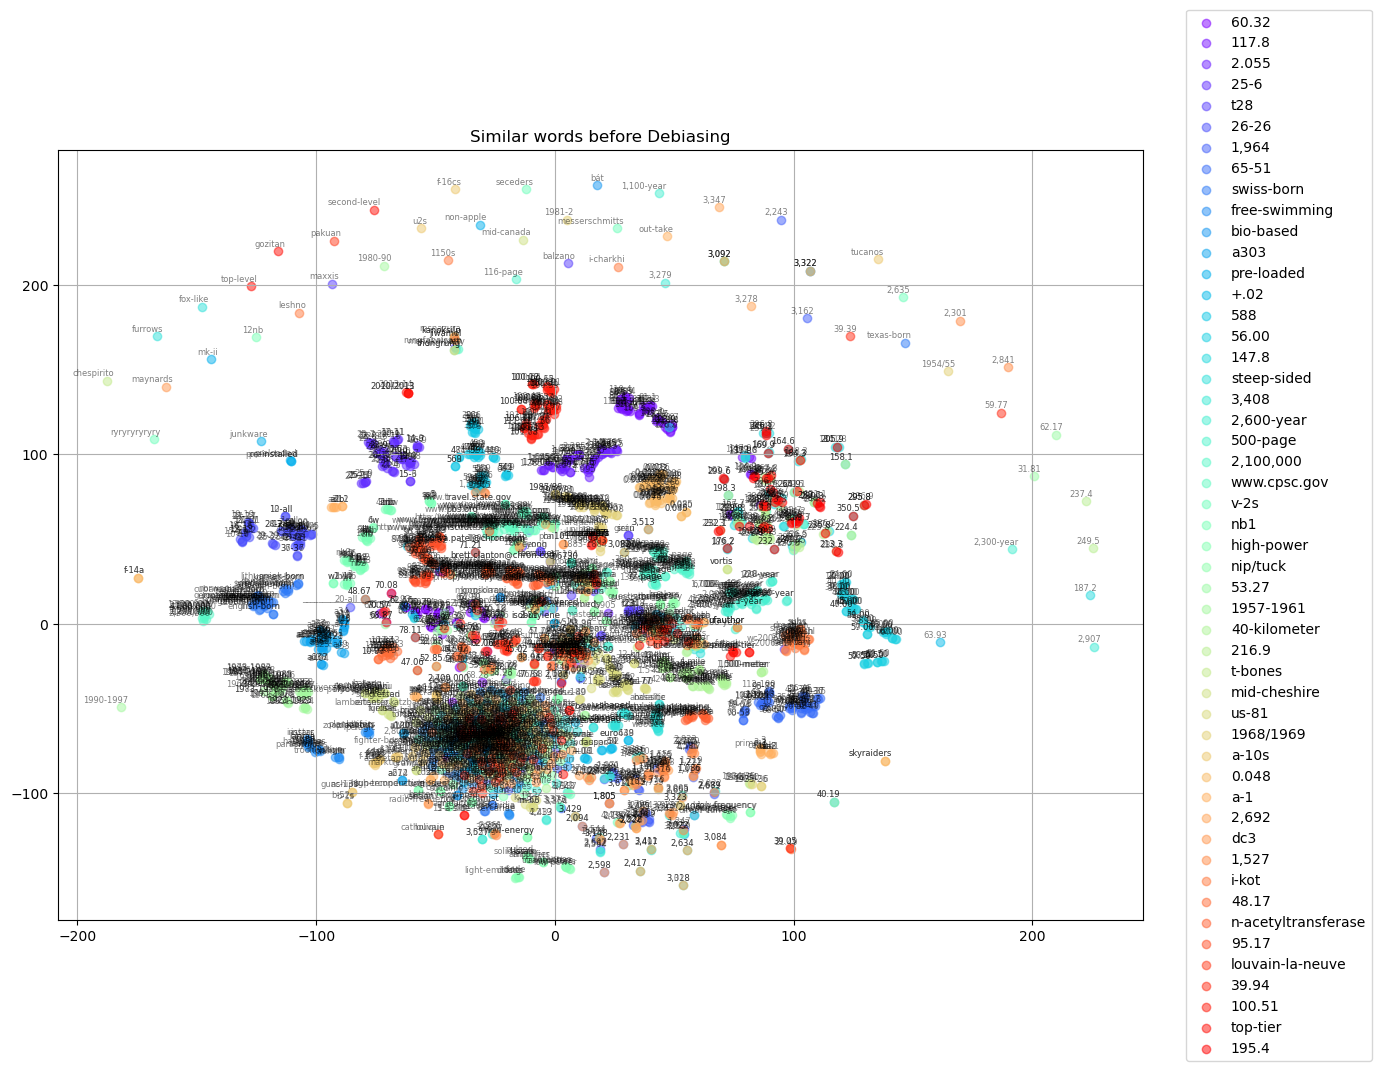

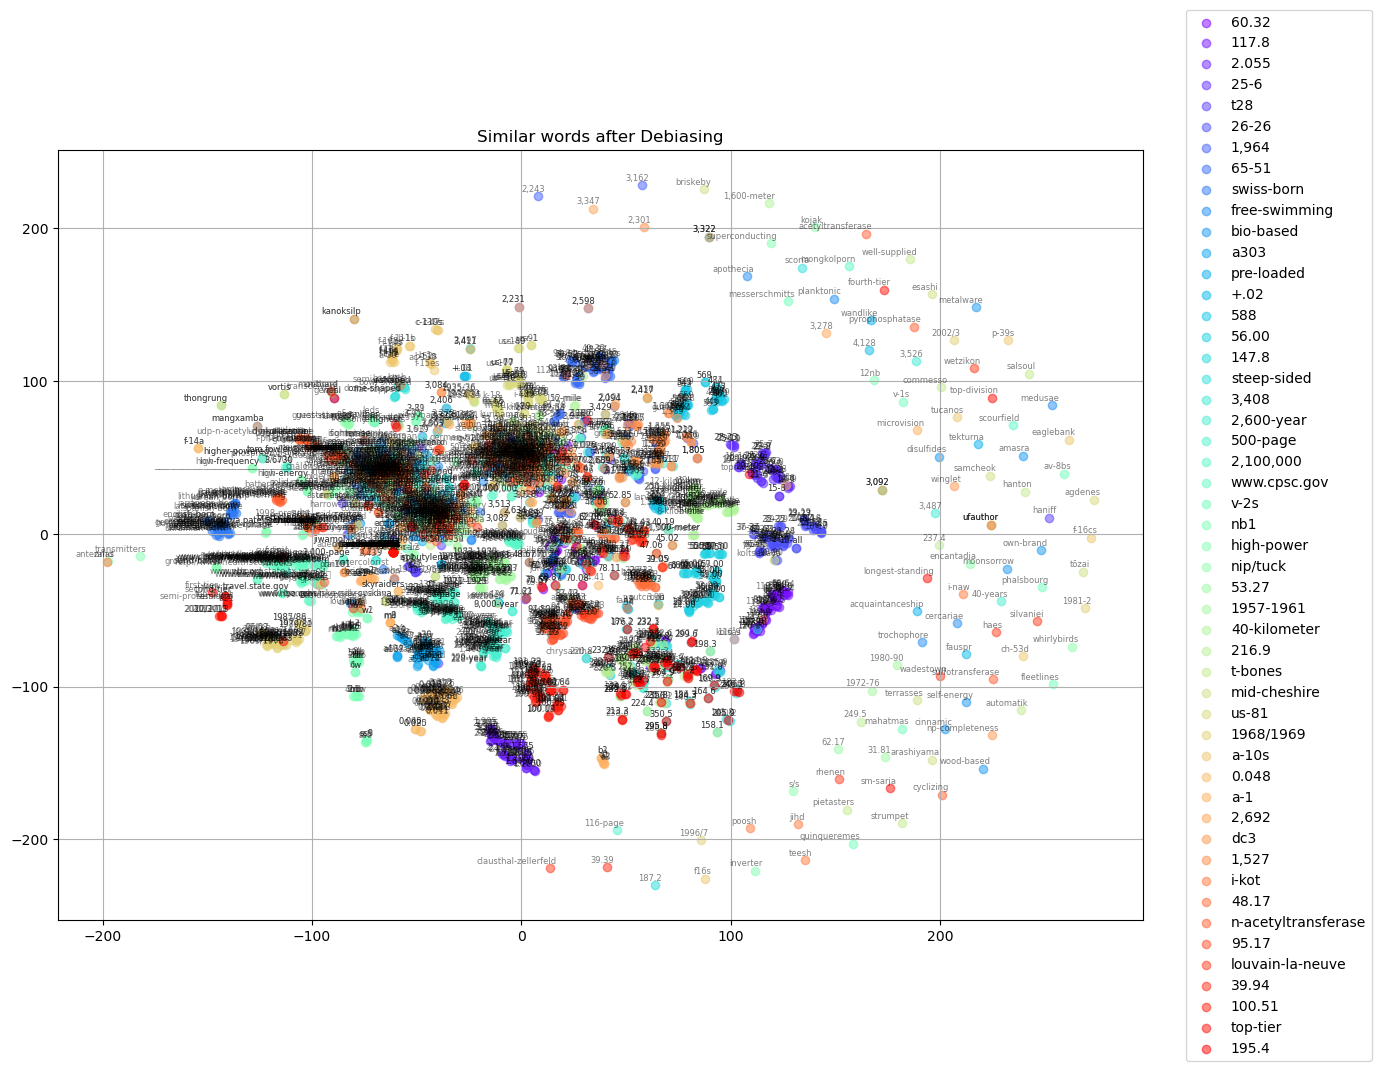

In [28]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = random_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, glove.model, model_debiased_punct, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.5)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.5)


### The Gendered words

In [47]:
# use when gender is excluded from the vocabulary
#Getting a limited vocabulary to debias the embeddings.
vocab_gender, vectors_gender, word2idx_gender, dict_vec_gender = glove.limit_vocab(
    vectors, word2idx, vocab, exclude=vocab_cleaned, exclude_punct=True)

#add the vectors_punct to the deb_vect_gender

all_g_vectors = np.vstack([deb_vect_gender, vectors_gender])
all_g_words = deb_vocab_gender+vocab_gender
#paste the two dictionaries together
w2i_g_all = {w: i for i, w in enumerate(all_g_words)}
dict_g_all = get_debiased_dict(all_g_vectors, w2i_g_all)


100%|██████████| 400000/400000 [00:00<00:00, 609953.27it/s]


Size of limited vocabulary: 496


In [29]:
#add the vectors_punct to the deb_vect_gender

all_g_vectors = deb_vect_gender
all_g_words = deb_vocab_gender
#paste the two dictionaries together
w2i_g_all = deb_word2idx_gender
dict_g_all = deb_dict_gender


In [31]:
all_g_vectors.shape

(327185, 300)

In [33]:
#get gender specific words in vocab_clean
gender_specific_words=[word for word in gender_specific if word in vocab_cleaned]

In [35]:
random_g_words = np.random.choice(gender_specific_words, size=50)


In [37]:
print(len(random_g_words))
print(random_g_words)


50
['businesswoman' 'chairwoman' 'granddaughters' 'duchesses' 'blokes' 'nuns'
 'tash' 'wife' 'wenches' 'horsemen' 'empresses' 'princess' 'chica'
 'housewives' 'heroines' 'grandfather' 'estrogen' 'housewives' 'paleface'
 'chairwomen' 'godmother' 'roon' 'obstetrics' 'toms' 'codger' 'female'
 'blowsy' 'him' 'hens' 'men' 'stallion' 'ladies' 'divorcee' 'councilwoman'
 'socialite' 'maiden' 'daddies' 'schoolgirl' 'gynecological' 'witch'
 'spokesmen' 'brides' 'girls' 'tash' 'belle' 'feminism' 'countrywoman'
 'nuh' 'horsemen' 'ter']


In [39]:
#get the neighbors of the original vectors
k_neigh_original_g = get_k_nearest_neighbors(
    random_g_words, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)
list_neigh_original_g = get_list_neighbors(k_neigh_original_g)
#get the neighbors of the debiased vectors
k_neigh_debiased = get_k_nearest_neighbors(
    random_g_words, dict_g_all, all_g_words, all_g_vectors, w2i_g_all, k=50)


100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


In [40]:
len(k_neigh_debiased)
print(len(list(k_neigh_debiased.keys())))
print(len(list(k_neigh_original_g.keys())))


47
47


In [41]:
#create gender word list for word in both k_neigh_debiased.keys() and k_neigh_original_g.keys()
gender_words= [word for word in k_neigh_debiased.keys() if word in k_neigh_original_g.keys()]

In [42]:
len(gender_words)

47

In [44]:
#get the distances to neighbors before and after debiasing
distances_original_g, distances_debiased_g = get_distance_to_neighbors(gender_words, list_neigh_original_g,
                                                                   dict_vec_cleaned, dict_g_all)
#get dataframe of distances from distances_original and distances_debiased
df_neigh_distances = get_df_distances(
    distances_original_g, distances_debiased_g)
#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average = df_neigh_distances[[
    'word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#frequencies of neighbors
neig_freq2 = get_frequency_original_neighbors(
    gender_words, list_neigh_original_g, dict_g_all, all_g_words, all_g_vectors, w2i_g_all, neighbours_num=50)
df2 = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])
#merge the two dataframes on the word column
#merge df and df average on word
df_merged_punct = df2.merge(df_average, on='word')
#df=pd.concat([df,df_merged], axis=1, keys='words')


1it [00:01,  1.67s/it]

councilwoman
congresswoman
woman


2it [00:03,  1.66s/it]

congresswoman
councilwoman


3it [00:04,  1.65s/it]

daughters
sisters
granddaughter
daughter
grandsons


12it [00:19,  1.63s/it]

girl
daughter
lady
granddaughter
prince
daughters


16it [00:26,  1.62s/it]

grandpa
granddaughter
nephew
sister
father
daughters
daughter
aunt


25it [00:40,  1.62s/it]

girl
females
men
male
woman


27it [00:44,  1.62s/it]

so
they
out
after
later
did


29it [00:47,  1.62s/it]

boys
woman
wives
women
female


31it [00:50,  1.63s/it]

women
gentleman
girls


33it [00:53,  1.63s/it]

businesswoman
chairwoman
congresswoman


35it [00:57,  1.63s/it]

opener


37it [01:00,  1.63s/it]

girl


42it [01:08,  1.63s/it]

boy
women
male
ladies
she
boys


47it [01:16,  1.63s/it]


In [45]:
df_merged_gender=df_merged_punct

In [46]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_merged_gender['word'],
              y=df_merged_gender['distance_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_merged_gender['word'],
              y=df_merged_gender['distance_debiased'], name='Debiased Embeddings'))
#add title
fig.update_layout(
    title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random from excluded vocabulary')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()


In [53]:
model_debiased_gender = create_KeyedVectors(all_g_vectors, all_g_words, 300)
model_original= create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)


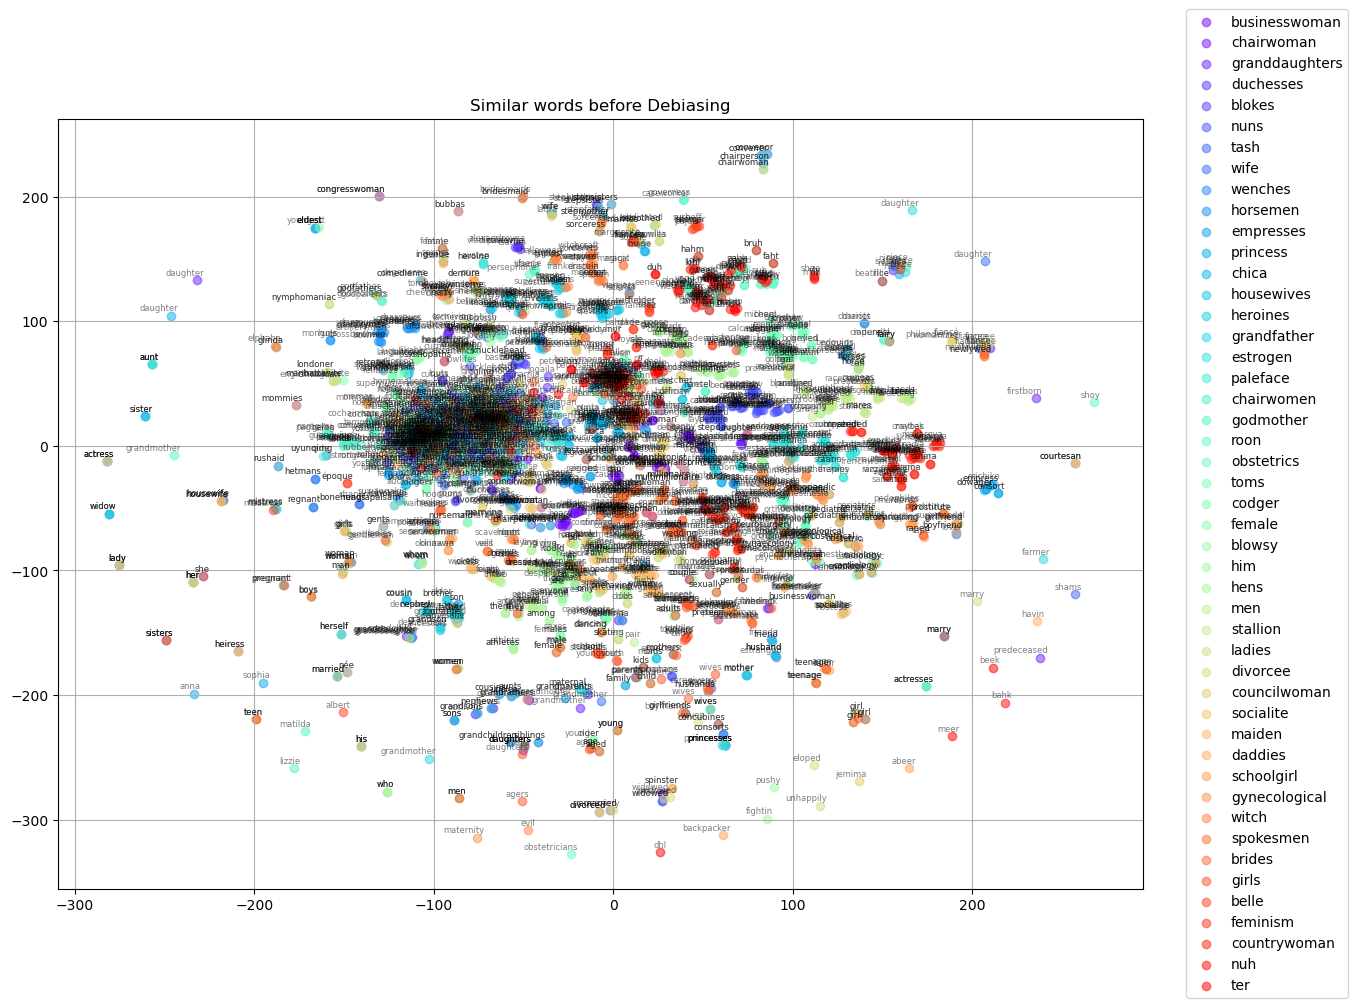

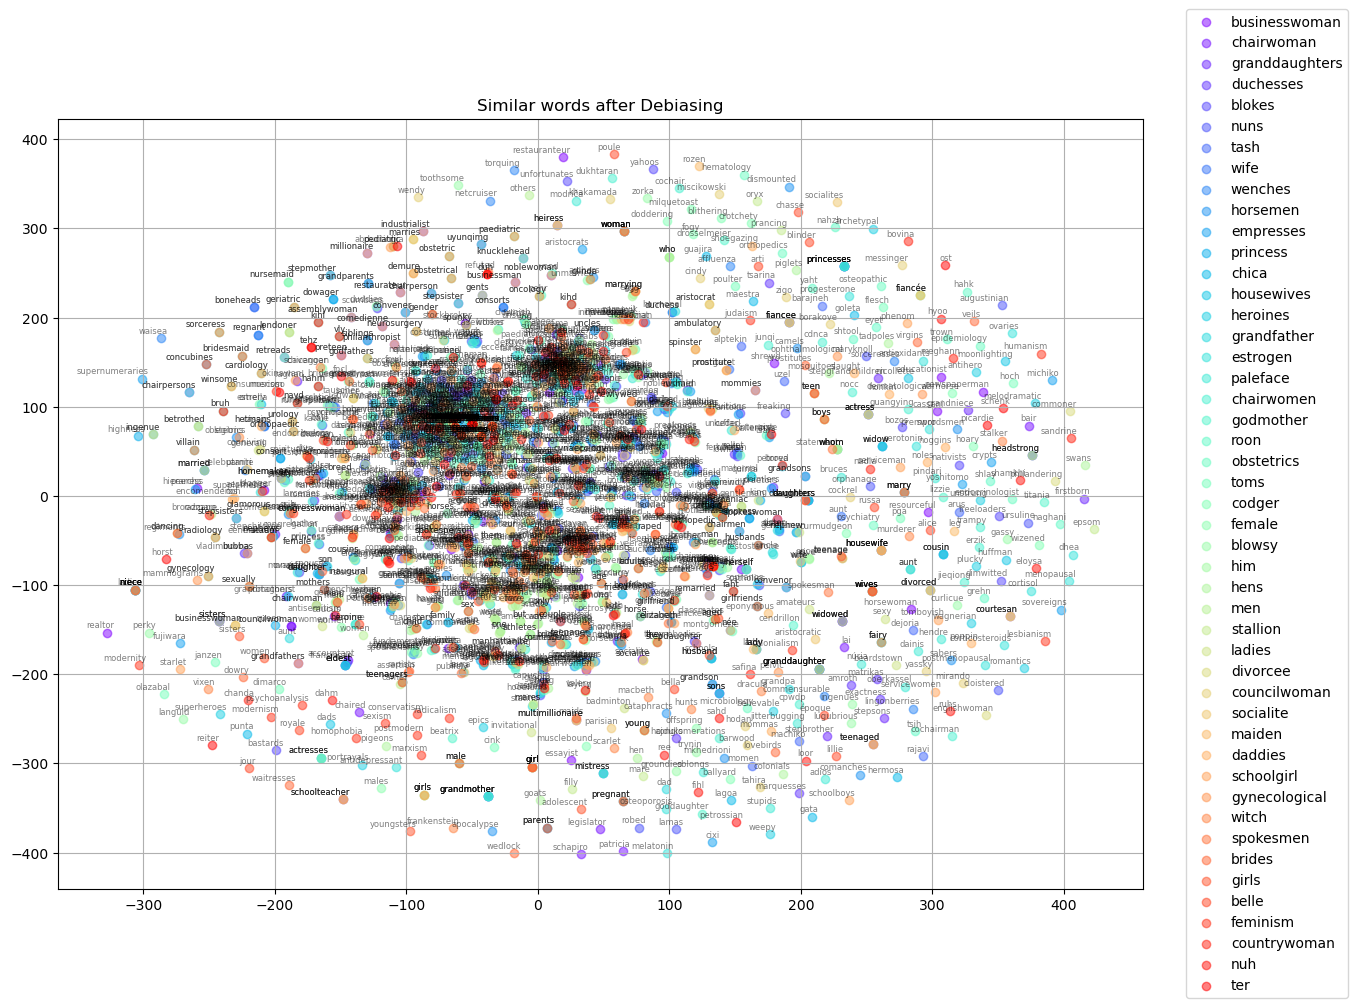

In [55]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = gender_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, model_debiased_gender, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.5)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.5)


In [65]:
bias_df3 = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, gender_words, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df3, "Gender bias on occupations (original vs debiased)", "Occupations")


### Neutral words

In [67]:
print(occupations)
print(len(occupations))

['assistant', 'secretary', 'data scientist', 'scientist', 'politician', 'janitor', 'hairdresser', 'teacher', 'bartender', 'midwife', 'doctor', 'ballerina', 'dancer', 'pediatrician', 'surgeon', 'physician', 'shopkeeper', 'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant', 'vocalists', 'guitarists', 'carpenter', 'clerk', 'manager', 'supervisor', 'driver', 'software developer', 'lawyer', 'pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro', 'lecturer', 'salesperson', 'homemaker', 'receptionist', 'librarian', 'nanny', 'bookkeeper', 'stylist', 'housekeeper', 'guidance counselor', 'skipper', 'protege', 'philosopher', 'captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher', 'pilot', 'boss']
64


In [70]:
#get the occupations taht are in the vocab_cleaned
occupations_in_vocab=[word for word in occupations if word in vocab_cleaned]
print(len(occupations_in_vocab))

59


In [71]:
#get the neighbors of the original vectors
k_neigh_original_g = get_k_nearest_neighbors(
    occupations_in_vocab, dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)
list_neigh_original_g = get_list_neighbors(k_neigh_original_g)
#get the neighbors of the debiased vectors
k_neigh_debiased = get_k_nearest_neighbors(
    occupations_in_vocab, dict_g_all, all_g_words, all_g_vectors, w2i_g_all, k=50)


100%|██████████| 59/59 [01:35<00:00,  1.63s/it]


In [72]:
len(k_neigh_debiased)
print(len(list(k_neigh_debiased.keys())))
print(len(list(k_neigh_original_g.keys())))


55
55


In [73]:
#create gender word list for word in both k_neigh_debiased.keys() and k_neigh_original_g.keys()
neutral_words= [word for word in k_neigh_debiased.keys() if word in k_neigh_original_g.keys()]

In [74]:
#get the distances to neighbors before and after debiasing
distances_original_g, distances_debiased_g = get_distance_to_neighbors(neutral_words, list_neigh_original_g,
                                                                       dict_vec_cleaned, dict_g_all)
#get dataframe of distances from distances_original and distances_debiased
df_neigh_distances = get_df_distances(
    distances_original_g, distances_debiased_g)
#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average = df_neigh_distances[[
    'word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#frequencies of neighbors
neig_freq2 = get_frequency_original_neighbors(
    neutral_words, list_neigh_original_g, dict_g_all, all_g_words, all_g_vectors, w2i_g_all, neighbours_num=50)
df2 = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])
#merge the two dataframes on the word column
#merge df and df average on word
df_merged_punct = df2.merge(df_average, on='word')
#df=pd.concat([df,df_merged], axis=1, keys='words')


2it [00:03,  1.65s/it]

department


3it [00:04,  1.65s/it]

university
institute


4it [00:06,  1.65s/it]

influential


6it [00:09,  1.65s/it]

stylist


10it [00:16,  1.63s/it]

professor


31it [00:50,  1.63s/it]

prosecutors
husband


43it [01:10,  1.63s/it]

linguist
assistant


45it [01:13,  1.63s/it]

hairdresser


49it [01:20,  1.63s/it]

navy


54it [01:28,  1.64s/it]

airlines


55it [01:29,  1.63s/it]


In [76]:
df_merged_neutral=df_merged_punct

In [77]:
#plot the average distance to neighbors before and after debiasing
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Bar(x=df_merged_neutral['word'],
              y=df_merged_neutral['distance_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_merged_neutral['word'],
              y=df_merged_neutral['distance_debiased'], name='Debiased Embeddings'))
#add title
fig.update_layout(
    title_text='Average cosine distance to neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Words Chosen at Random from excluded vocabulary')
#change y axis title
fig.update_yaxes(title_text='Average Cosine Distance to Neighbors')

fig.show()

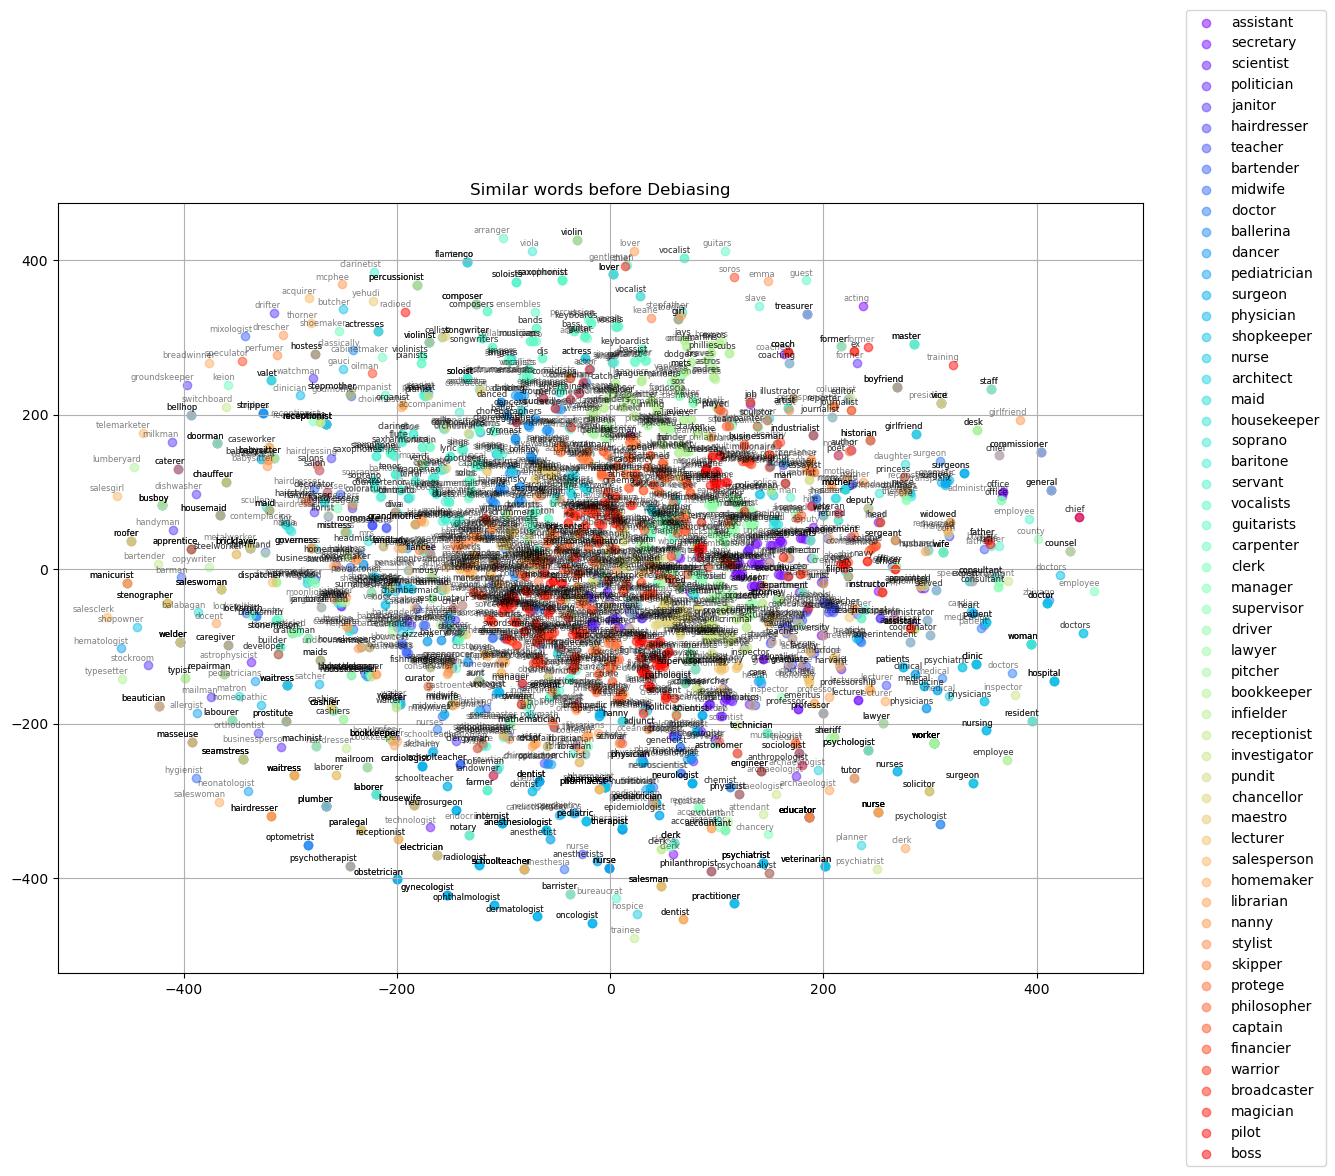

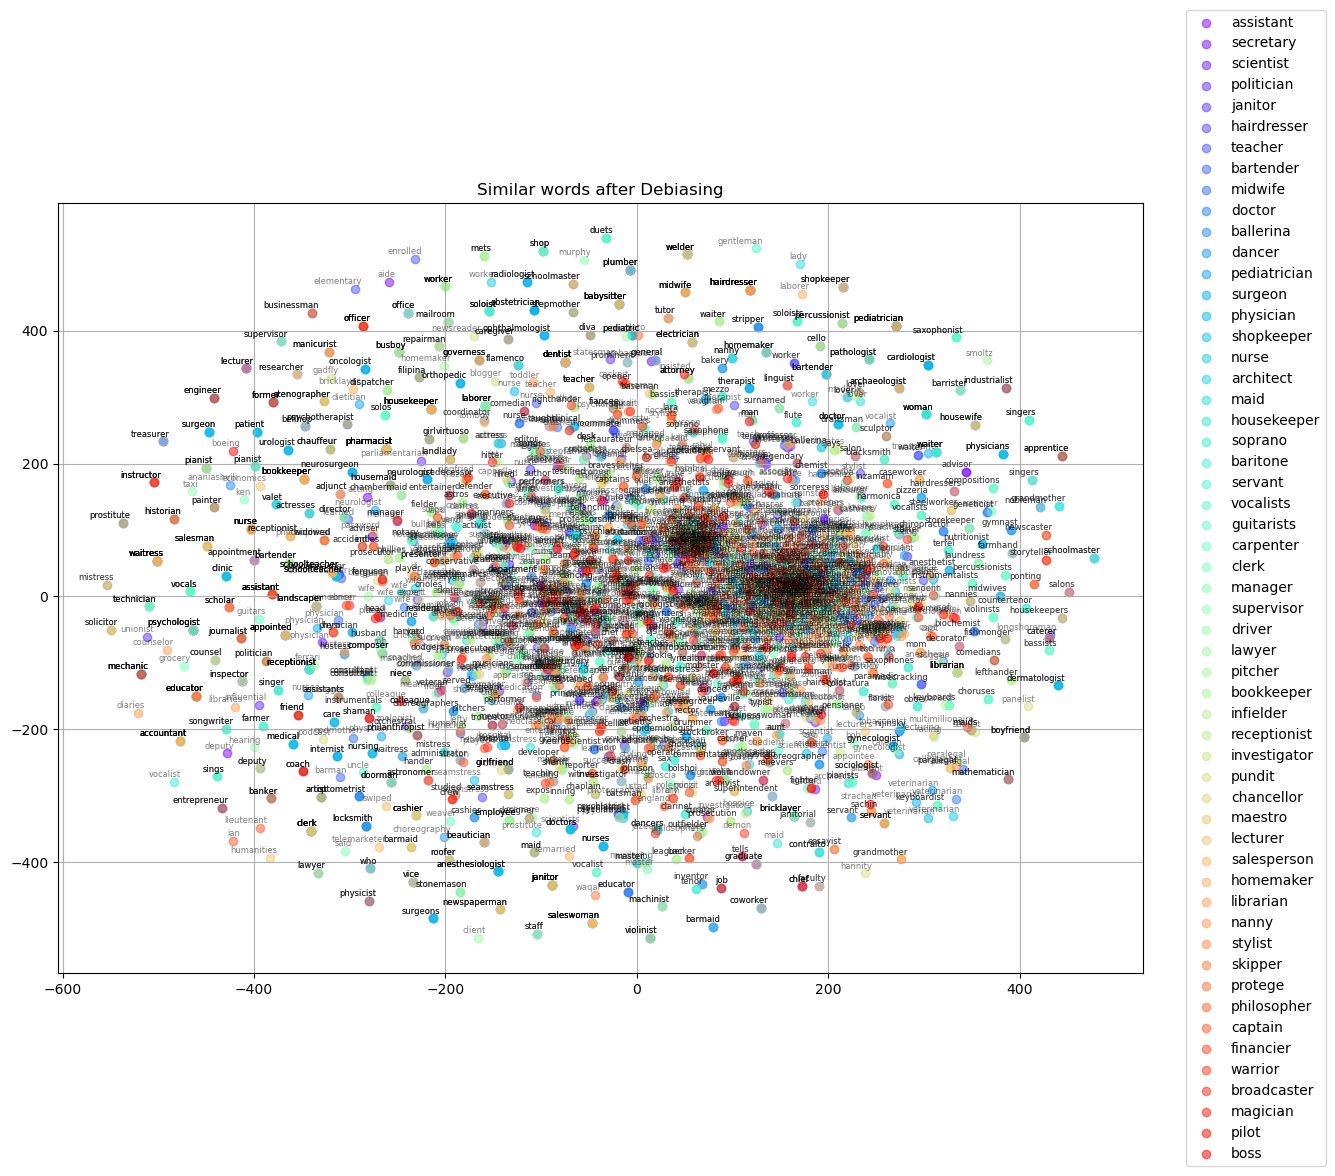

In [78]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
keys = neutral_words
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys, model_original, model_debiased_gender, 50)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=42)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.5)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.5)


In [82]:
calculate_bias_by_clustering(
    model_original, model_debiased_gender, gender_words, 50)


----------------------------------
word: businesswoman
 most-similar-before: ('socialite', 'businessman', 'entrepreneur', 'homemaker', 'philanthropist', 'restaurateur', 'multimillionaire', 'housewife', 'politician', 'schoolteacher', 'actress', 'shrewd', 'woman', 'millionaire', 'businessperson', 'heiress', 'seamstress', 'educationist', 'resourceful', 'blogger', 'horsewoman', 'activist', 'educator', 'congresswoman', 'realtor', 'noblewoman', 'restauranteur', 'businesswomen', 'stockbroker', 'comedienne', 'banker', 'feisty', 'newspaperman', 'woeser', 'kadeer', 'ballerina', 'courtesan', 'cassani', 'triathlete', 'psychotherapist', 'councilwoman', 'peeress', 'widowed', 'vivacious', 'essayist', 'stuntwoman', 'industrialist', 'pastoralist', 'accountant', 'headstrong')
 most-similar-after: ('chairwoman', 'councilwoman', 'colt', 'sisters', 'fella', 'congresswoman', 'gentlemen', 'monastery', 'queen', 'nephew', 'granddaughter', 'mothers', 'gelding', 'woman', 'gals', 'indication', 'daughter', 'female

In [85]:

def bias_by_neighbors(word_list, dict_vect, vocab, vectors, w2i, neighbours_num=100):

    tuples = []
    for word in tqdm(word_list):

        _,top = get_topK_neighbors(
            word, dict_vect, vocab, vectors, w2i, k=neighbours_num)

        m = 0
        f = 0
        for t in top:
            if gender_bias_original[t] > 0:
                f += 1
            else:
                m += 1

        tuples.append(
            (word, gender_bias_original[word], gender_bias_after_debiasing[word], f, m))

    return tuples


In [87]:
bias_neigh=bias_by_neighbors(neutral_words, deb_dict_gender, deb_vocab_gender,
                  deb_vect_gender, deb_word2idx_gender, neighbours_num=50)


100%|██████████| 55/55 [01:30<00:00,  1.64s/it]


In [101]:
#get a dataframe of the bias by neighbors (bias_neigh)
df_bias_neigh=pd.DataFrame(bias_neigh, columns=['word', 'bias_original', 'bias_debiased', 'f', 'm'])
df_bias_neigh['diff_neigh']=df_bias_neigh['f']-df_bias_neigh['m']




In [104]:
df_bias_neigh


word  bias_original  bias_debiased   f   m  diff_neigh
0      assistant      -0.065951      -0.027665  13  37         -24
1      secretary      -0.058412       0.013040   8  42         -34
2      scientist      -0.075615       0.029652  16  34         -18
3     politician      -0.092756      -0.009252  11  39         -28
4        janitor      -0.012418      -0.034179  29  21           8
5    hairdresser       0.156028      -0.012090  29  21           8
6        teacher       0.043036       0.033999  20  30         -10
7      bartender       0.045976      -0.022241  18  32         -14
8        midwife       0.211095      -0.009966  34  16          18
9         doctor       0.003835       0.013995  12  38         -26
10     ballerina       0.243311       0.002899  22  28          -6
11        dancer       0.156638      -0.003845  27  23           4
12  pediatrician       0.115340       0.029326  27  23           4
13       surgeon      -0.045878       0.045211  16  34         -18
14     physician      -0.061494      -0.008957   9  41         -32
15    shopkeeper       0.000090      -0.005154  27  23           4
16         nurse       0.187380       0.028587  15  35         -20
17     architect      -0.103531      -0.030053  13  37         -24
18          maid       0.189010       0.003246  20  30         -10
19   housekeeper       0.180631       0.007171  26  24           2
20       soprano       0.179808      -0.008862  18  32         -14
21      baritone      -0.029812       0.012173  30  20          10
22       servant      -0.032303      -0.001536  17  33         -16
23     vocalists       0.125470      -0.011701  30  20          10
24    guitarists      -0.045485      -0.017798  30  20          10
25     carpenter      -0.017176       0.017039  19  31         -12
26         clerk       0.012428      -0.009814  24  26          -2
27       manager      -0.135291       0.032888  12  38         -26
28    supervisor       0.079018       0.047344  12  38         -26
29        driver      -0.089208      -0.014199   6  44         -38
30        lawyer      -0.038840       0.005068   9  41         -32
31       pitcher      -0.146017       0.016872  13  37         -24
32    bookkeeper       0.060888      -0.044456  28  22           6
33     infielder      -0.112174       0.024298  26  24           2
34  receptionist       0.169494      -0.056358  25  25           0
35  investigator      -0.015325       0.017255  21  29          -8
36        pundit      -0.016963       0.006606  22  28          -6
37    chancellor      -0.027802      -0.018355  15  35         -20
38       maestro      -0.067613      -0.015412  31  19          12
39      lecturer      -0.014610      -0.020184  17  33         -16
40   salesperson       0.053806      -0.039657  35  15          20
41     homemaker       0.204461       0.004034  20  30         -10
42     librarian       0.100899      -0.020090  23  27          -4
43         nanny       0.181539       0.007216  15  35         -20
44       stylist       0.179165      -0.014029  24  26          -2
45       skipper      -0.099069       0.020075  15  35         -20
46       protege      -0.033505      -0.038677  30  20          10
47   philosopher      -0.094847       0.011105  14  36         -22
48       captain      -0.109352       0.004064   7  43         -36
49     financier      -0.121391      -0.043628  24  26          -2
50       warrior       0.054117       0.061111  17  33         -16
51   broadcaster      -0.093981       0.042416  23  27          -4
52      magician      -0.047643       0.007665  23  27          -4
53         pilot      -0.042544       0.005960  13  37         -24
54          boss      -0.108633       0.000979  14  36         -22

In [107]:
#plot bias by neighbors side by side to the bias_original and bias_debiased
fig = go.Figure()
fig.add_trace(go.Bar(x=df_bias_neigh['word'],
                     y=df_bias_neigh['bias_original'], name='Original Embeddings'))
fig.add_trace(go.Bar(x=df_bias_neigh['word'],
                     y=df_bias_neigh['bias_debiased'], name='Debiased Embeddings'))

#add title
fig.update_layout(
    title_text='Bias scores and biased Neighbors before and after debiasing')
#change x axis title
fig.update_xaxes(title_text='Neutral Occupations')
#change y axis title
fig.update_yaxes(title_text='Bias by Neighbors')
fig.show()

fig1 = go.Figure()
#add a line with the diff_neigh column
fig1.add_trace(go.Scatter(x=df_bias_neigh['word'],
                         y=df_bias_neigh['diff_neigh'], name='Bias by Neighbors', mode='lines+markers'))
fig1.show()


In [75]:
def get_words_from_pairs(definitional_pairs):
  """"  
  Gets the words from the pairs of words
  ----
  :param definitional_pairs: list of pairs of words
  :return: list of words
  """
  # Turning the pairs into words to add afterwards to the vocabulary
  definitional_list = []
  for pair in definitional_pairs:
    for word in pair:
      definitional_list.append(word)
  return definitional_list


In [95]:
equalized_words=get_words_from_pairs(equalizing_lists['gender'])

In [98]:
len(equalized_words)

104

## Other Attempts

### Name Analysis

In [ ]:
gender_bias_original2 = compute_direct_bias(
    deb_dict_gender, neutral_words, race_direction)


In [ ]:
names_white= list(w.lower() for w in names_ethnicity['White'] if w.lower() in set(vocab_cleaned))
names_black= list(w.lower() for w in names_ethnicity['Black'] if w.lower() in set(vocab_cleaned))
names_latino= list(w.lower() for w in names_ethnicity['Hispanic'] if w.lower() in set(vocab_cleaned))
#euroam_names_emb= list(w for w in euroam_names if w in set(vocab_cleaned))

In [ ]:
bias_df_names = get_bias_score_df_from_list(
    gender_bias_original, gender_bias_after_debiasing, names_black, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df_names, "Gender bias on english names (original vs debiased)", "Names")

In [ ]:
k_neigh= get_k_nearest_neighbors(names_black[:17], dict_vec_cleaned, vocab_cleaned, vectors_cleaned, word2idx_cleaned, k=50)

In [ ]:
k_neigh

In [ ]:
list_neigh = get_list_neighbors(k_neigh)


In [ ]:
get_frequency_original_neighbors(
    names_black[:17], list_neigh, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)


In [ ]:
model_debiased = create_KeyedVectors(deb_vect_gender, deb_vocab_gender, 50)


In [ ]:
gendered_words_before_and_after=finding_neighbors_before_after(names_black, model_original, model_debiased, topn=50)

In [ ]:
keys2=names_black
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(keys2, model_original, model_debiased, topn)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words before Debiasing', keys2, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys2, db_embeddings_en_2d, word_clusters, 0.7)


In [ ]:
# get tuples of biases and counts of masculine/feminine NN for each word (for bias-by-neighbors)

def bias_by_neighbors(dict_vect, vocab, vectors, w2i, neighbours_num=100):

    tuples = []
    for word in tqdm(vocab):

        _, top = topK(word, dict_vect, vocab, vectors, w2i,
                      k=neighbours_num+5)

        m = 0
        f = 0
        for t in top:
            if gender_bias_original[t] < 0:
                m += 1
            else:
                f += 1

        tuples.append(
            (word, gender_bias_original[word], gender_bias_after_debiasing[word], m, f))

    return tuples


bias_by_neighbors(dict_vec_cleaned, vocab_cleaned,
                  vectors_cleaned, word2idx_cleaned, neighbours_num=50)

gendered_names = ["ruth", "charlotte", "abigail", "sophie", "nichole",
                  "emma", "olivia", "ava", "isabella", "sophia", "charlotte", "mia", "amelia"]
# "james", "john", "robert", "michael", "william", "david", "richard", "joseph", "thomas", "ariel", "mike", "nurse", "secretary", "nursery"]
#words_chosen = ["miss", "mrs", "mr", "john", "rachel",
# "wife", "mom", "family", "father", "lady", "he", "she"]

gendered_words_before_and_after = finding_neighbors_before_after(
    gendered_names, model_original, model_debiased, topn=3)
keys2 = gendered_names
embedding_clusters, db_embedding_clusters, word_clusters = get_embeddings_neighbors(
    keys2, model_original, model_debiased, topn)

n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=2, n_components=2,
                        init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
db_embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(
    db_embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


tsne_plot_similar_words('Similar words before Debiasing',
                        keys2, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys2, db_embeddings_en_2d, word_clusters, 0.7)


In [ ]:
race_direction = identify_bias_subspace(
    deb_dict_gender, def_set_race, 1, centralizing=True)

### MAC Scores

In [ ]:
targets = [["he", "she"],
            ["his", "hers"],
            ["son", "daughter"],
            ["father", "mother"],
            ["male", "female"],
            ["boy", "girl"],
            ["uncle", "aunt"]]

Attribtutes = [["manager", "executive", "doctor", "lawyer", "programmer", "scientist",
                "soldier", "supervisor", "rancher", "janitor", "firefighter", "officer"], ["secretary", "nurse", "clerk", "artist", "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist", "receptionist", "counselor"]]


In [ ]:
debiasedMAC, debiasedDistribution=multiclass_evaluation_MAC(
    debiased_dict, targets, Attribtutes)

originalMAC,originalDistribution = multiclass_evaluation_MAC(
    dict_vec_cleaned, targets, Attribtutes)


In [ ]:
from scipy.stats import ttest_rel, spearmanr
statistics, pvalue = ttest_rel(originalDistribution, debiasedDistribution)


### Bias by neighbor

In [ ]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(
    gender_bias_original, def_sets['gender'], 1000, word2idx_cleaned)


In [ ]:
biased_words=female_words+male_words

In [ ]:


k_neighbors=finding_neighbors_before_after(
    biased_words, model_original, model_debiased, topn=100)


In [ ]:
#take k_neighbors dictionary and

In [ ]:
calculate_bias_by_clustering(model_original, model_debiased, biased_words, 50)

#### Race

In [ ]:

deb_vect_race, deb_vocab_race, deb_word2idx_race, deb_dict_race = hard_debias(vectors,
                                                                              dict_vectors,
                                                                              word2idx_cleaned,
                                                                              vocab_cleaned,
                                                                              equalizing_lists['race'],
                                                                              def_set_race,
                                                                              1,
                                                                              normalize_dir=False,
                                                                              normalize=None,
                                                                              centralizing=True)


In [ ]:
neig_freq_race= get_frequency_original_neighbors(
    random_words, list_neigh, deb_dict_race, deb_vocab_race, deb_vect_race, deb_word2idx_race, neighbours_num=50)


In [ ]:
pd.DataFrame(neig_freq_race, columns=['word', 'previous_neighbours', 'freq'])

In [ ]:
## Finding race Debiased Words.
race_debiased = create_KeyedVectors(deb_vect_race, deb_vocab_race, 50)
finding_neighbors_before_after(random_words, model_original, race_debiased, topn=3)
joined_debiased = create_KeyedVectors(deb_vect_joined, deb_vocab_joined, 50)
finding_neighbors_before_after(
    random_words, model_original, joined_debiased, topn=2)


### Saving Embeddings on a txt file.
- And loading them as a Gensim model object

In [ ]:
#Saving the debiased vectors and vocab to a text file
glove.save_in_word2vec_format(
    debiased_vectors, debiased_vocab, "./Data/vecs.50.cleaned.txt")

#Loading the vectors into a KeyedVectors object 'model_cleaned' that we can use to find the most similar words to a given word
model_cleaned, _, _ = load_word_vectors(
    fname="./Data/vecs.50.cleaned.txt")

